# DSI Project 2 Regression Challenge: <br>Ames housing price prediction model

<i>Predict the price of homes at sale for the Ames Iowa Housing dataset, with lowest root-mean-squared-error as Kaggle's scoring objective.</i>

### Problem Statement

Build a regression model to predict housing sale prices in Ames, Iowa.
This model should support prospective homeowners assess list price reasonableness within Ames, Iowa, and inform their purchase decision.

As a project pre-requisite, this requires creating and iteratively refining a regression model to address the Ames, Iowa data set from Kaggle. Kaggle submissions determine outcome quality based on root mean squared error (rsme).

### Executive Summary

From our analysis, the linear regression model (with StandardScaler) provides a reasonable regression model for ballpark housing list price estimates.

Coefficients with the largest predictive value in the model showed house size, quality, features and location were significant variables influencing housing prices in Ames, Iowa. While we visit only 18 features in this model, we are predicting ~80% of the sale price (CV score), and this is generally good enough as a ballpark figure.

As seen in the data set, there are many features, quantitative and qualitative, to examine within real estate. Ultimately, relating these factors to a seller's own evaluation of the property price as well as a buyer's propensity to purchase the asset is important.

Taking the buy-side view, location proximity to places of interest (or work) could be very important for a buyer that wants to lease out the home. A buyer who wants to purchase a home for personal stay may be more interested in living area and community features of the location. Past sales prices per house are also very natural and important starting points when buying houses; most would not buy a house that has an unreasonably inflated price tag.

Do note that the applicability of this model is restricted in many ways to the Ames, Iowa, area. We would not, for example, expect this model to work at all in Singapore, where it would be quite unrealistic to evaluate number of fireplaces a house has. Indeed, the neighborhoods variables used would not be applicable beyond this dataset.

Given more time, it could be interesting to engineer some features dealing with price per square foot on an assessable net living area. Understanding how the overall quality surveys were done as well as ranking neighborhood districts from different angles (e.g. community value to homeowners) may also be interesting data points worth collecting. Exploring some price indicies as a proxy for past sales prices may also be interesting (e.g. S&P/Case-Shiller U.S. National Homes Price Index).

---

### Content

#### Within this notebook:
1. [Prologue](#Prologue:-First,-some-context...)
2. [Methodology and Preliminary Analysis](#Methodology-and-Preliminary-Analysis)
3. [Pre-processing: Baseline View](#Baseline-View)
4. [Pre-processing: Exploratory Visualization](#Exploratory-Visualization)
5. [Pre-processing: Correlation heatmaps and feature engineering](#Correlation-heatmaps-and-feature-engineeringg)
6. [More Pre-processing](#More-Pre-processing)
7. [Modelling](#Modelling)
8. [Production Model](#Production-Model)
9. [Conclusions and Further Research](#Conclusions-and-Further-Research)
10. [References & Bibliography](#References-&-Bibliography)


### Prologue: First, some context...

#### Context

When reviewing general information about Ames, Iowa, I wanted to get a current picture of how residents in the city lived and some potential considerations around home ownership, as well as general home supply.

#### Data USA has provided some interesting (recent) insight into this, which I summarize below:

- 2019 home ownership rate: 59% (percentage of homes that are owner-occupied)
- Most travel by car to work (~75%; average commute of 18min); on average 2 cars per household
- 2019 median property value: 170.6k USD (vs 180.4k USD in 2018)

#### Highlighted features of the Kaggle dataset:

- Many variables available, both qualitative (e.g. nominal / ordinal / discrete survey data) and quantitative (e.g. continuous square-footage data on the house).
- Data set from city official sources and are for individual residential properties sold in Ames, IA from 2006 to 2010
- A quick Google search (see below) indicates the sample represents around 12% of the total population (~3,000 out of ~24,000 in 2011) -- this has an impact on how much data we should drop
- Ames data documentation <a href = 'http://jse.amstat.org/v19n3/decock/DataDocumentation.txt'> linked here</a>.



![Number of Homes](images/google_ames_numberofhomes.png)
<center><i> Source: Google Search </center></i>

[Back to contents](#Content)

### Methodology and Preliminary Analysis

#### Data

Three files were provided:

1. `train.csv` -- training data 

2. `test.csv` -- test data for model to make predictions (`SalePrice` target variable is not in test set)

3. `sample_sub_reg.csv` -- Sample of correctly formatted submission towards Kaggle


#### Methodology

My focus will be on examining the quality of various linear regression models with key steps below:

1. Set up and review baseline data against data dictionary
2. Build scatter plots and box plots for exploratory visualization
3. Other pre-processing & feature engineering
4. Model tuning, Kaggle submissions, and selection of production model
5. Interpret production model

Process will iterate through steps to refine model.

#### Functions for efficiency and visualizations for data exploration and inferences
With over 80 columns, the data set can be sliced in many ways. It would be inefficient to initiate preprocessing manually feature by feature.

To improve efficiency, we will define functions for pre-processing steps, e.g. visualization.

Doing some exploratory visualization prior to encoding should also help test for relevance to our target variable, `SalePrice`. If there is little impact, we may consider dropping anyway.

From a base review of the data documentation text provided with the data set, we understand that there are nominal, ordinal, discrete, and continuous variables. We will use scatterplots (for numerical data) and boxplots (for categorical data) for the "as-is" data set analysis.


#### Managing Nulls and Outliers
We will need to make decisions after exploration on treatment of null values (drop or impute).

As regards to outlier treatment, where there are large enough numbers of outlier clusters, we can consider separate analysis to explore any important indicators within the training dataset. Otherwise, we should consider log-transformation or dropping outlier observations.

[Back to contents](#Content)

### Pre-processing

#### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

#### Global parameters

In [2]:
# set global parameters
plt.rcParams['font.size'] = '16'

# for f-string next line
nl = '\n'

[Back to contents](#Content)

### Baseline View

In [3]:
# Read training data
df_train = pd.read_csv('./datasets/train.csv')

# Column name transformations: lower case, snake_case
df_train.columns = df_train.columns.str.lower()
df_train.columns = df_train.columns.str.replace(' ', '_')

# View head
df_train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [5]:
# Baseline summary statistics
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2.198000e+03,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
ms_subclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
lot_frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
lot_area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
overall_qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
overall_cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
year_built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
year_remod/add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
mas_vnr_area,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0


#### Display more information

In [6]:
# Define items to display in function
# To show: value counts, null counts ratio, and zero counts ratio
def show_more_info(df, col_name):
    print('----- %s -----' % col_name),
    display(
        df[col_name].value_counts(),
        f'Percentage of null_counts: {df[col_name].isnull().sum() / 2051 * 100}%',
        f'Percentage of zero_counts: {(2051 - df[col_name].astype(bool).sum(axis=0)) / 2051 * 100}%'
    )

# Show more info
# pd.set_option('display.max_rows', None)  # toggle if needed, not very useful

for col in df_train.columns:
    show_more_info(df_train, col)

----- id -----


2049    1
749     1
2556    1
507     1
505     1
       ..
1068    1
1066    1
1062    1
1060    1
2047    1
Name: id, Length: 2051, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- pid -----


533250050    1
907410100    1
531385020    1
532376250    1
528235190    1
            ..
531451150    1
905201030    1
923252100    1
903456130    1
527450110    1
Name: pid, Length: 2051, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- ms_subclass -----


20     770
60     394
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: ms_subclass, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- ms_zoning -----


RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- lot_frontage -----


60.0     179
70.0      96
80.0      94
50.0      90
65.0      71
        ... 
119.0      1
117.0      1
137.0      1
22.0       1
195.0      1
Name: lot_frontage, Length: 118, dtype: int64

'Percentage of null_counts: 16.089712335446123%'

'Percentage of zero_counts: 0.0%'

----- lot_area -----


9600     34
7200     27
6000     26
10800    19
9000     18
         ..
7711      1
7697      1
9742      1
9738      1
8190      1
Name: lot_area, Length: 1476, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- street -----


Pave    2044
Grvl       7
Name: street, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- alley -----


Grvl    85
Pave    55
Name: alley, dtype: int64

'Percentage of null_counts: 93.1740614334471%'

'Percentage of zero_counts: 0.0%'

----- lot_shape -----


Reg    1295
IR1     692
IR2      55
IR3       9
Name: lot_shape, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- land_contour -----


Lvl    1843
HLS      85
Bnk      80
Low      43
Name: land_contour, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- utilities -----


AllPub    2049
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- lot_config -----


Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: lot_config, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- land_slope -----


Gtl    1953
Mod      88
Sev      10
Name: land_slope, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- neighborhood -----


NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- condition_1 -----


Norm      1767
Feedr      109
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- condition_2 -----


Norm      2025
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition_2, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- bldg_type -----


1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- house_style -----


1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- overall_qual -----


5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       9
1       4
Name: overall_qual, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- overall_cond -----


5    1168
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: overall_cond, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- year_built -----


2005    102
2006     99
2007     78
2004     72
2003     64
       ... 
1898      1
1896      1
1892      1
1875      1
1872      1
Name: year_built, Length: 113, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- year_remod/add -----


1950    262
2006    139
2007    123
2005    100
2004     83
       ... 
1952      9
2010      8
1983      7
1981      6
1982      3
Name: year_remod/add, Length: 61, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- roof_style -----


Gable      1619
Hip         397
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: roof_style, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- roof_matl -----


CompShg    2025
Tar&Grv      15
WdShngl       5
WdShake       4
ClyTile       1
Membran       1
Name: roof_matl, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- exterior_1st -----


VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    276
Plywood    152
CemntBd     90
BrkFace     64
WdShing     45
AsbShng     33
Stucco      27
BrkComm      3
CBlock       2
Stone        2
AsphShn      1
ImStucc      1
Name: exterior_1st, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- exterior_2nd -----


VinylSd    721
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    185
CmentBd     90
Wd Shng     63
BrkFace     34
Stucco      30
AsbShng     28
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: exterior_2nd, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- mas_vnr_type -----


None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

'Percentage of null_counts: 1.0726474890297415%'

'Percentage of zero_counts: 0.0%'

----- mas_vnr_area -----


0.0      1216
120.0      11
176.0      10
200.0      10
210.0       9
         ... 
576.0       1
796.0       1
573.0       1
372.0       1
428.0       1
Name: mas_vnr_area, Length: 373, dtype: int64

'Percentage of null_counts: 1.0726474890297415%'

'Percentage of zero_counts: 59.28815212091663%'

----- exter_qual -----


TA    1247
Gd     697
Ex      81
Fa      26
Name: exter_qual, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- exter_cond -----


TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- foundation -----


PConc     926
CBlock    863
BrkTil    221
Slab       34
Stone       5
Wood        2
Name: foundation, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- bsmt_qual -----


TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: bsmt_qual, dtype: int64

'Percentage of null_counts: 2.681618722574354%'

'Percentage of zero_counts: 0.0%'

----- bsmt_cond -----


TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: bsmt_cond, dtype: int64

'Percentage of null_counts: 2.681618722574354%'

'Percentage of zero_counts: 0.0%'

----- bsmt_exposure -----


No    1339
Av     288
Gd     203
Mn     163
Name: bsmt_exposure, dtype: int64

'Percentage of null_counts: 2.8278888347147735%'

'Percentage of zero_counts: 0.0%'

----- bsmtfin_type_1 -----


GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: bsmtfin_type_1, dtype: int64

'Percentage of null_counts: 2.681618722574354%'

'Percentage of zero_counts: 0.0%'

----- bsmtfin_sf_1 -----


0.0       657
24.0       17
16.0       10
20.0        7
384.0       7
         ... 
718.0       1
900.0       1
918.0       1
1619.0      1
1159.0      1
Name: bsmtfin_sf_1, Length: 821, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 32.03315455875183%'

----- bsmtfin_type_2 -----


Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: bsmtfin_type_2, dtype: int64

'Percentage of null_counts: 2.7303754266211606%'

'Percentage of zero_counts: 0.0%'

----- bsmtfin_sf_2 -----


0.0       1803
294.0        5
539.0        3
72.0         3
180.0        3
          ... 
232.0        1
1393.0       1
95.0         1
351.0        1
120.0        1
Name: bsmtfin_sf_2, Length: 205, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 87.908337396392%'

----- bsmt_unf_sf -----


0.0       165
384.0      14
672.0      11
728.0      10
816.0       9
         ... 
266.0       1
20.0        1
521.0       1
109.0       1
1211.0      1
Name: bsmt_unf_sf, Length: 967, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 8.044856167723061%'

----- total_bsmt_sf -----


0.0       54
864.0     51
1040.0    20
672.0     20
816.0     17
          ..
1129.0     1
946.0      1
1236.0     1
2220.0     1
973.0      1
Name: total_bsmt_sf, Length: 892, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 2.6328620185275478%'

----- heating -----


GasA    2018
GasW      20
Wall       6
Grav       5
OthW       2
Name: heating, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- heating_qc -----


Ex    1065
TA     597
Gd     319
Fa      67
Po       3
Name: heating_qc, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- central_air -----


Y    1910
N     141
Name: central_air, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- electrical -----


SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- 1st_flr_sf -----


864     31
1040    22
816     13
912     13
936     12
        ..
1740     1
1738     1
1736     1
1722     1
1987     1
Name: 1st_flr_sf, Length: 915, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- 2nd_flr_sf -----


0       1191
728       15
504       14
546       12
600       10
        ... 
1098       1
1096       1
1092       1
1088       1
1721       1
Name: 2nd_flr_sf, Length: 504, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 58.06923451974646%'

----- low_qual_fin_sf -----


0       2018
80         3
205        2
512        1
515        1
513        1
479        1
473        1
397        1
371        1
259        1
53         1
1064       1
572        1
528        1
514        1
450        1
436        1
390        1
384        1
362        1
360        1
312        1
234        1
156        1
144        1
140        1
120        1
114        1
108        1
697        1
Name: low_qual_fin_sf, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 98.39102876645539%'

----- gr_liv_area -----


864     25
1040    20
1092    19
1200    16
1456    15
        ..
1894     1
1898     1
2057     1
1908     1
2037     1
Name: gr_liv_area, Length: 1053, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- bsmt_full_bath -----


0.0    1200
1.0     824
2.0      23
3.0       2
Name: bsmt_full_bath, dtype: int64

'Percentage of null_counts: 0.09751340809361286%'

'Percentage of zero_counts: 58.508044856167714%'

----- bsmt_half_bath -----


0.0    1923
1.0     122
2.0       4
Name: bsmt_half_bath, dtype: int64

'Percentage of null_counts: 0.09751340809361286%'

'Percentage of zero_counts: 93.75914188200878%'

----- full_bath -----


2    1096
1     900
3      45
0       8
4       2
Name: full_bath, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.39005363237445145%'

----- half_bath -----


0    1308
1     725
2      18
Name: half_bath, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 63.773768893222815%'

----- bedroom_abvgr -----


3    1108
2     544
4     265
1      75
5      41
6      12
0       5
8       1
Name: bedroom_abvgr, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.24378352023403219%'

----- kitchen_abvgr -----


1    1960
2      88
0       2
3       1
Name: kitchen_abvgr, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.09751340809361286%'

----- kitchen_qual -----


TA    1047
Gd     806
Ex     151
Fa      47
Name: kitchen_qual, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- totrms_abvgrd -----


6     597
7     475
5     407
8     228
4     146
9      98
10     49
11     22
12     13
3      12
2       1
14      1
13      1
15      1
Name: totrms_abvgrd, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- functional -----


Typ     1915
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sal        2
Sev        2
Name: functional, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- fireplaces -----


0    1000
1     898
2     146
3       6
4       1
Name: fireplaces, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 48.75670404680644%'

----- fireplace_qu -----


Gd    523
TA    407
Fa     59
Ex     31
Po     31
Name: fireplace_qu, dtype: int64

'Percentage of null_counts: 48.75670404680644%'

'Percentage of zero_counts: 0.0%'

----- garage_type -----


Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64

'Percentage of null_counts: 5.509507557289127%'

'Percentage of zero_counts: 0.0%'

----- garage_yr_blt -----


2005.0    105
2007.0     84
2006.0     80
2004.0     72
2003.0     66
         ... 
1919.0      1
1896.0      1
1895.0      1
1917.0      1
1933.0      1
Name: garage_yr_blt, Length: 100, dtype: int64

'Percentage of null_counts: 5.558264261335934%'

'Percentage of zero_counts: 0.0%'

----- garage_finish -----


Unf    849
RFn    579
Fin    509
Name: garage_finish, dtype: int64

'Percentage of null_counts: 5.558264261335934%'

'Percentage of zero_counts: 0.0%'

----- garage_cars -----


2.0    1136
1.0     524
3.0     263
0.0     113
4.0      13
5.0       1
Name: garage_cars, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 5.509507557289127%'

----- garage_area -----


0.0       113
440.0      70
576.0      69
484.0      52
528.0      46
         ... 
808.0       1
752.0       1
858.0       1
422.0       1
1174.0      1
Name: garage_area, Length: 514, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 5.509507557289127%'

----- garage_qual -----


TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64

'Percentage of null_counts: 5.558264261335934%'

'Percentage of zero_counts: 0.0%'

----- garage_cond -----


TA    1868
Fa      47
Gd      12
Po       8
Ex       2
Name: garage_cond, dtype: int64

'Percentage of null_counts: 5.558264261335934%'

'Percentage of zero_counts: 0.0%'

----- paved_drive -----


Y    1861
N     151
P      39
Name: paved_drive, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- wood_deck_sf -----


0      1075
100      53
144      46
192      43
120      40
       ... 
73        1
75        1
186       1
87        1
857       1
Name: wood_deck_sf, Length: 322, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 52.41345685031692%'

----- open_porch_sf -----


0      912
48      40
36      38
40      34
32      29
      ... 
288      1
282      1
278      1
4        1
547      1
Name: open_porch_sf, Length: 223, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 44.46611409068747%'

----- enclosed_porch -----


0      1724
112      13
96       10
144       6
84        6
       ... 
268       1
260       1
256       1
72        1
301       1
Name: enclosed_porch, Length: 159, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 84.05655777669429%'

----- 3ssn_porch -----


0      2025
153       3
168       3
144       2
216       1
323       1
255       1
245       1
508       1
304       1
290       1
224       1
182       1
86        1
180       1
176       1
162       1
150       1
140       1
120       1
96        1
407       1
Name: 3ssn_porch, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 98.73232569478303%'

----- screen_porch -----


0      1870
144       9
168       8
192       7
180       7
       ... 
208       1
204       1
198       1
196       1
385       1
Name: screen_porch, Length: 100, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 91.17503656752804%'

----- pool_area -----


0      2042
228       1
368       1
480       1
576       1
648       1
738       1
800       1
519       1
561       1
Name: pool_area, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 99.56118966357874%'

----- pool_qc -----


Gd    4
Fa    2
TA    2
Ex    1
Name: pool_qc, dtype: int64

'Percentage of null_counts: 99.56118966357874%'

'Percentage of zero_counts: 0.0%'

----- fence -----


MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: fence, dtype: int64

'Percentage of null_counts: 80.49731838127742%'

'Percentage of zero_counts: 0.0%'

----- misc_feature -----


Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: misc_feature, dtype: int64

'Percentage of null_counts: 96.83081423695758%'

'Percentage of zero_counts: 0.0%'

----- misc_val -----


0        1986
400        12
500         8
600         6
2000        5
450         5
700         4
4500        2
2500        2
3000        2
1200        2
6500        1
900         1
1500        1
455         1
1300        1
1150        1
650         1
800         1
54          1
17000       1
480         1
460         1
300         1
12500       1
8300        1
80          1
3500        1
Name: misc_val, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 96.83081423695758%'

----- mo_sold -----


6     352
7     303
5     257
4     208
3     168
8     167
10    123
9     109
2     104
11    103
1      79
12     78
Name: mo_sold, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- yr_sold -----


2007    498
2009    446
2006    438
2008    435
2010    234
Name: yr_sold, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- sale_type -----


WD       1781
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Oth         4
Con         4
Name: sale_type, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- saleprice -----


130000    25
140000    22
145000    20
135000    19
170000    16
          ..
403000     1
415298     1
179781     1
317000     1
264132     1
Name: saleprice, Length: 828, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

From the above views, we see a number of null counts and zero counts in some variables.

These need to be addressed. For now, we log them in lists.

In [7]:
# Create lists for high null counts and high zero counts
# Take threshold of "high" as 100, which is >5% of the data set.

# list_log = {
#     'list_high_nulls' : list_high_nulls, 
#     'list_high_zeroes' : list_high_zeroes
# }

list_high_nulls = []
list_high_zeroes = []

for col in df_train.columns:
    if df_train[col].isnull().sum() > 100:
        list_high_nulls.append(col)
    if df_train[col].astype(bool).sum(axis = 0) < (2051-100):
        list_high_zeroes.append(col)
        
print(
    f'List of null count > 100:\
    {nl}{nl}  {list_high_nulls}\
    {nl}{nl}{nl}List of zero count > 100:\
    {nl}{nl}  {list_high_zeroes}'
)

List of null count > 100:    

  ['lot_frontage', 'alley', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature']    


List of zero count > 100:    

  ['mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'half_bath', 'fireplaces', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val']


**Explore relevance of columns before deciding on treatment.**

Some columns that have high null values actually have meaning and should not need to be dropped. For example, a null value in `pool_qc` actually means that there is no pool.

Similarly, zero values in `pool_area` also reflect that there is no pool.

**Best to delay decision to drop or impute after exploring relevance.**

[Back to contents](#Content)

#### Typecasting
To allow quick access to columns, we will store categorical data as `category` dtypes. We can expect non-numerical variables (i.e. not `int` / `float`) to be categorical in nature.

We also want `saleprice` to be set as a `float` early on since we know this target variable should be continuous.

In [8]:
df_train['saleprice'] = df_train['saleprice'].astype('float64')

In [9]:
# Review planned selection of non-int/float dtypes
df_train.select_dtypes(exclude=['int64', 'float64']).head().T

,0,1,2,3,4
ms_zoning,RL,RL,RL,RL,RL
street,Pave,Pave,Pave,Pave,Pave
alley,NaN,NaN,NaN,NaN,NaN
lot_shape,IR1,IR1,Reg,Reg,IR1
land_contour,Lvl,Lvl,Lvl,Lvl,Lvl
utilities,AllPub,AllPub,AllPub,AllPub,AllPub
lot_config,CulDSac,CulDSac,Inside,Inside,Inside
land_slope,Gtl,Gtl,Gtl,Gtl,Gtl
neighborhood,Sawyer,SawyerW,NAmes,Timber,SawyerW
condition_1,RRAe,Norm,Norm,Norm,Norm


In [10]:
# Cast as 'category' dtype
df_train[df_train.select_dtypes(exclude=['int64', 'float64']).columns] = df_train[df_train.select_dtypes(exclude=['int64', 'float64']).columns].astype('category')

In [11]:
# Review dtypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               2051 non-null   int64   
 1   pid              2051 non-null   int64   
 2   ms_subclass      2051 non-null   int64   
 3   ms_zoning        2051 non-null   category
 4   lot_frontage     1721 non-null   float64 
 5   lot_area         2051 non-null   int64   
 6   street           2051 non-null   category
 7   alley            140 non-null    category
 8   lot_shape        2051 non-null   category
 9   land_contour     2051 non-null   category
 10  utilities        2051 non-null   category
 11  lot_config       2051 non-null   category
 12  land_slope       2051 non-null   category
 13  neighborhood     2051 non-null   category
 14  condition_1      2051 non-null   category
 15  condition_2      2051 non-null   category
 16  bldg_type        2051 non-null   category


In [12]:
df_train.select_dtypes(exclude = 'category').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   lot_frontage     1721 non-null   float64
 4   lot_area         2051 non-null   int64  
 5   overall_qual     2051 non-null   int64  
 6   overall_cond     2051 non-null   int64  
 7   year_built       2051 non-null   int64  
 8   year_remod/add   2051 non-null   int64  
 9   mas_vnr_area     2029 non-null   float64
 10  bsmtfin_sf_1     2050 non-null   float64
 11  bsmtfin_sf_2     2050 non-null   float64
 12  bsmt_unf_sf      2050 non-null   float64
 13  total_bsmt_sf    2050 non-null   float64
 14  1st_flr_sf       2051 non-null   int64  
 15  2nd_flr_sf       2051 non-null   int64  
 16  low_qual_fin_sf  2051 non-null   int64  
 17  gr_liv_area   

In [13]:
# Establish list for categorical variables
list_categorical = list(df_train.select_dtypes(include = 'category').columns)

#### Defining exploratory visualization functions

In [14]:
# Scatter plots -- useful for continuous / numerical data
# Scatter subplots
def draw_subplot_scatter(df, col_list):
    nrows = int(np.ceil(len(col_list)/3)) 
    fig, ax = plt.subplots(nrows = nrows, 
                           ncols = 3,
                           figsize = (16, nrows*4)
                          ) 
    ax = ax.ravel() 
    for i, column in enumerate(col_list): 
        sns.regplot(x = df[column],
                    y = df.saleprice,
                    ax = ax[i],
                    marker = 'o',
                    scatter_kws = {'facecolors':'blue',
                                   'alpha' : 0.1},
                    line_kws = {'color':'grey'}
                   )
        ax[i].set_title(f'{column} vs. saleprice', fontsize = 18)  
        ax[i].tick_params(labelsize = 12)
        ax[i].set_xlabel(column)
        ax[i].set_ylabel('saleprice')
    plt.tight_layout()

# Scatter dive
def draw_scatter(x_var, data,
                 y_var = 'saleprice', m = 'x', a = 0.1, 
                 **kwargs):
    plt.figure(figsize = (16,5))
    plt.style.use('seaborn-whitegrid')
    plt.scatter(x = x_var, y = y_var,
                data = data, marker = m, alpha = a,
                **kwargs)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()
    

# Box plots -- useful for categorical variables
# Categorical variables can be discrete, ordinal, or nominal variables
# Boxplot subplots
def draw_boxplots(df, col_list):
    nrows = int(np.ceil(len(col_list)/3)) 
    fig, ax = plt.subplots(nrows = nrows,
                           ncols = 3,
                           figsize = (16, nrows*4)
                          ) 
    ax = ax.ravel()
    for i, column in enumerate(col_list): 
        sns.boxplot(x = df[column], 
                    y = df.saleprice, 
                    width = 0.3, 
                    ax = ax[i], 
                    showmeans = True,
                    color='#ffffe6'
                   )
        ax[i].tick_params(labelsize = 12)
        ax[i].set_xlabel(column)
    plt.tight_layout()
    plt.show()
    
# Boxplot dive
def draw_boxplots_dive(df, column):
    plt.figure(figsize = (16,8))
    sns.boxplot(x = df[column], 
                y = df.saleprice,
                showmeans = True,
                color='#ffffe6')
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

[Back to contents](#Content)

### Exploratory Visualization

#### Visualizing categorical variables
Boxplots are used to visualize categorical variables below.

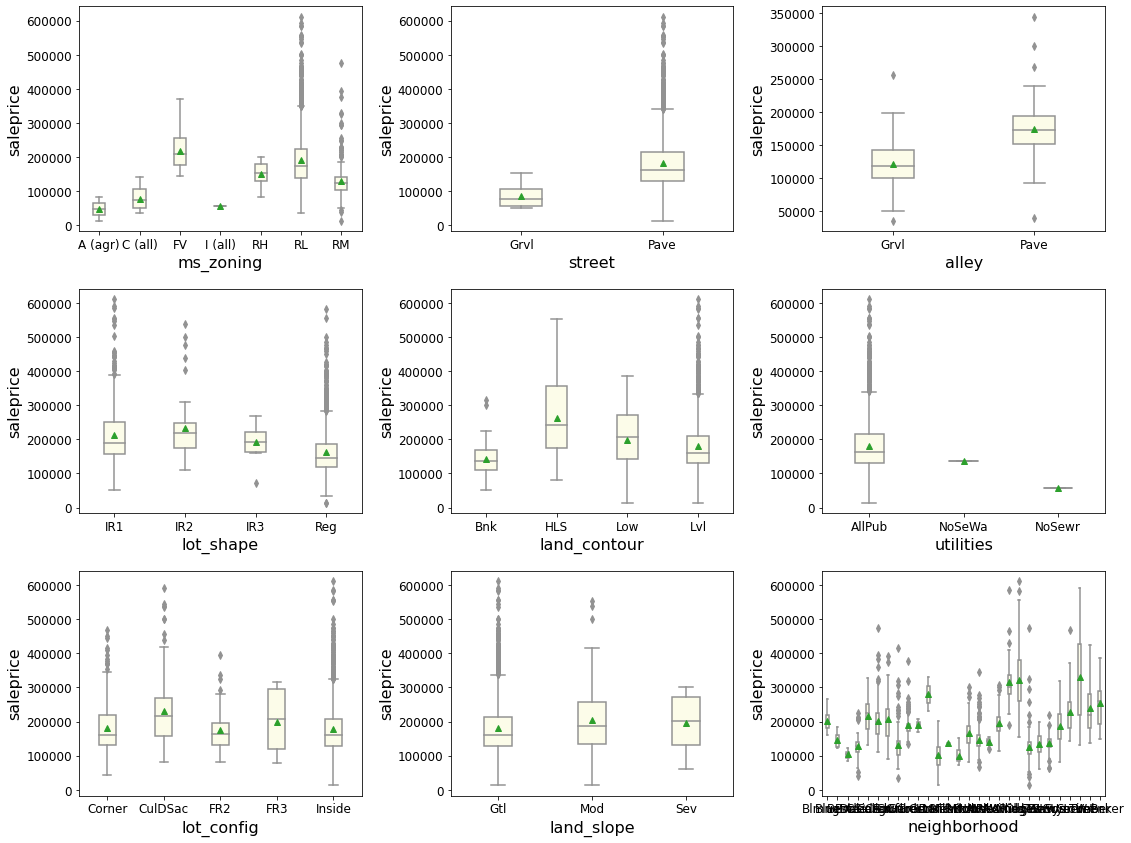

In [170]:
# Split boxplots for ease of interpretation into batches of 9
# len(list_categorical) / 9 = ~5

draw_boxplots(df_train, list_categorical[:9])

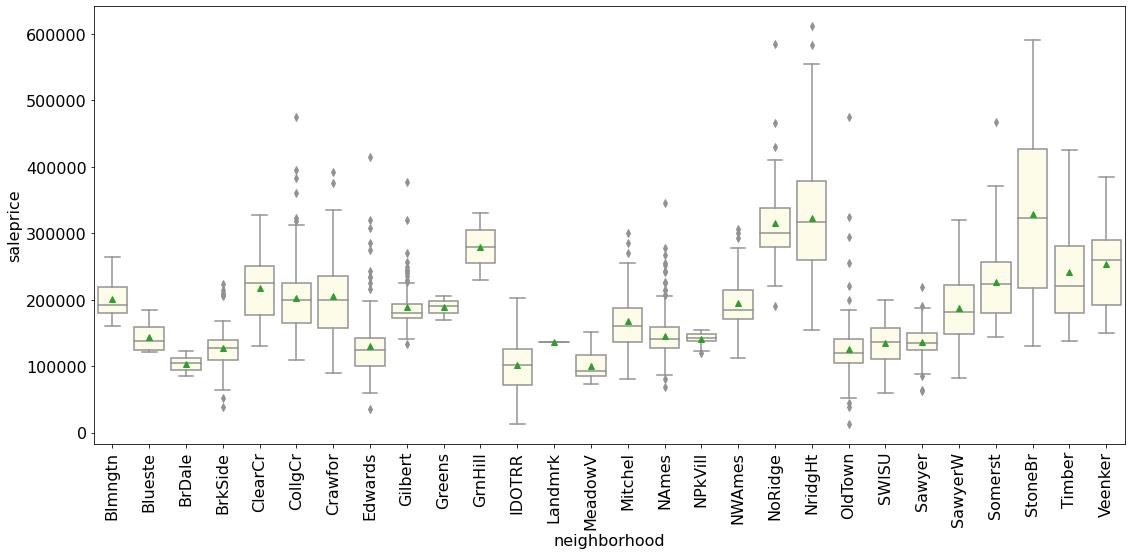

In [16]:
draw_boxplots_dive(df_train, 'neighborhood')

In [17]:
# View value counts
df_neighborhood_count = pd.DataFrame(
    df_train['neighborhood'].value_counts(),
    index = df_train['neighborhood'].value_counts().index,
            )

df_neighborhood_count

,neighborhood
NAmes,310
CollgCr,180
OldTown,163
Edwards,143
Somerst,130
NridgHt,122
Gilbert,116
Sawyer,111
SawyerW,87
NWAmes,87


We see the boxplots of `neighborhood` with very varied plots. Interestingly, NAmes with the most value counts (310) has a relatively narrow interquartile range in comparison to StoneBr (value count = 38).

We do also expect this intuitively due to the nature of real estate to price certain locales differently. For example, Orchard Road in Singapore is one of the more expensive districts, being a major shopping belt.

Some boxes are "squeezed" within a small `saleprice` interquartile range, like BrDale, while some others are spread across a very wide range, like StoneBr.

This is definitely a feature to keep an eye on because:
- the boxplots shows different shapes and medians across categories (with means generally pretty close to the medians across categories), hinting at different characteristics per locale, and
- there is sound real-world reasoning on why different locales within a city can command different sale prices.

In [18]:
# Set aside list of high value count neighborhood elements to consider as dummies
list_neighborhood_dummies = list(df_neighborhood_count[df_neighborhood_count['neighborhood'] > 100].index)
list_neighborhood_dummies

['NAmes',
 'CollgCr',
 'OldTown',
 'Edwards',
 'Somerst',
 'NridgHt',
 'Gilbert',
 'Sawyer']

In [19]:
list_other_col = [elem for elem in df_train.columns if 
                  ((elem != 'neighborhood') & (elem != 'saleprice'))]

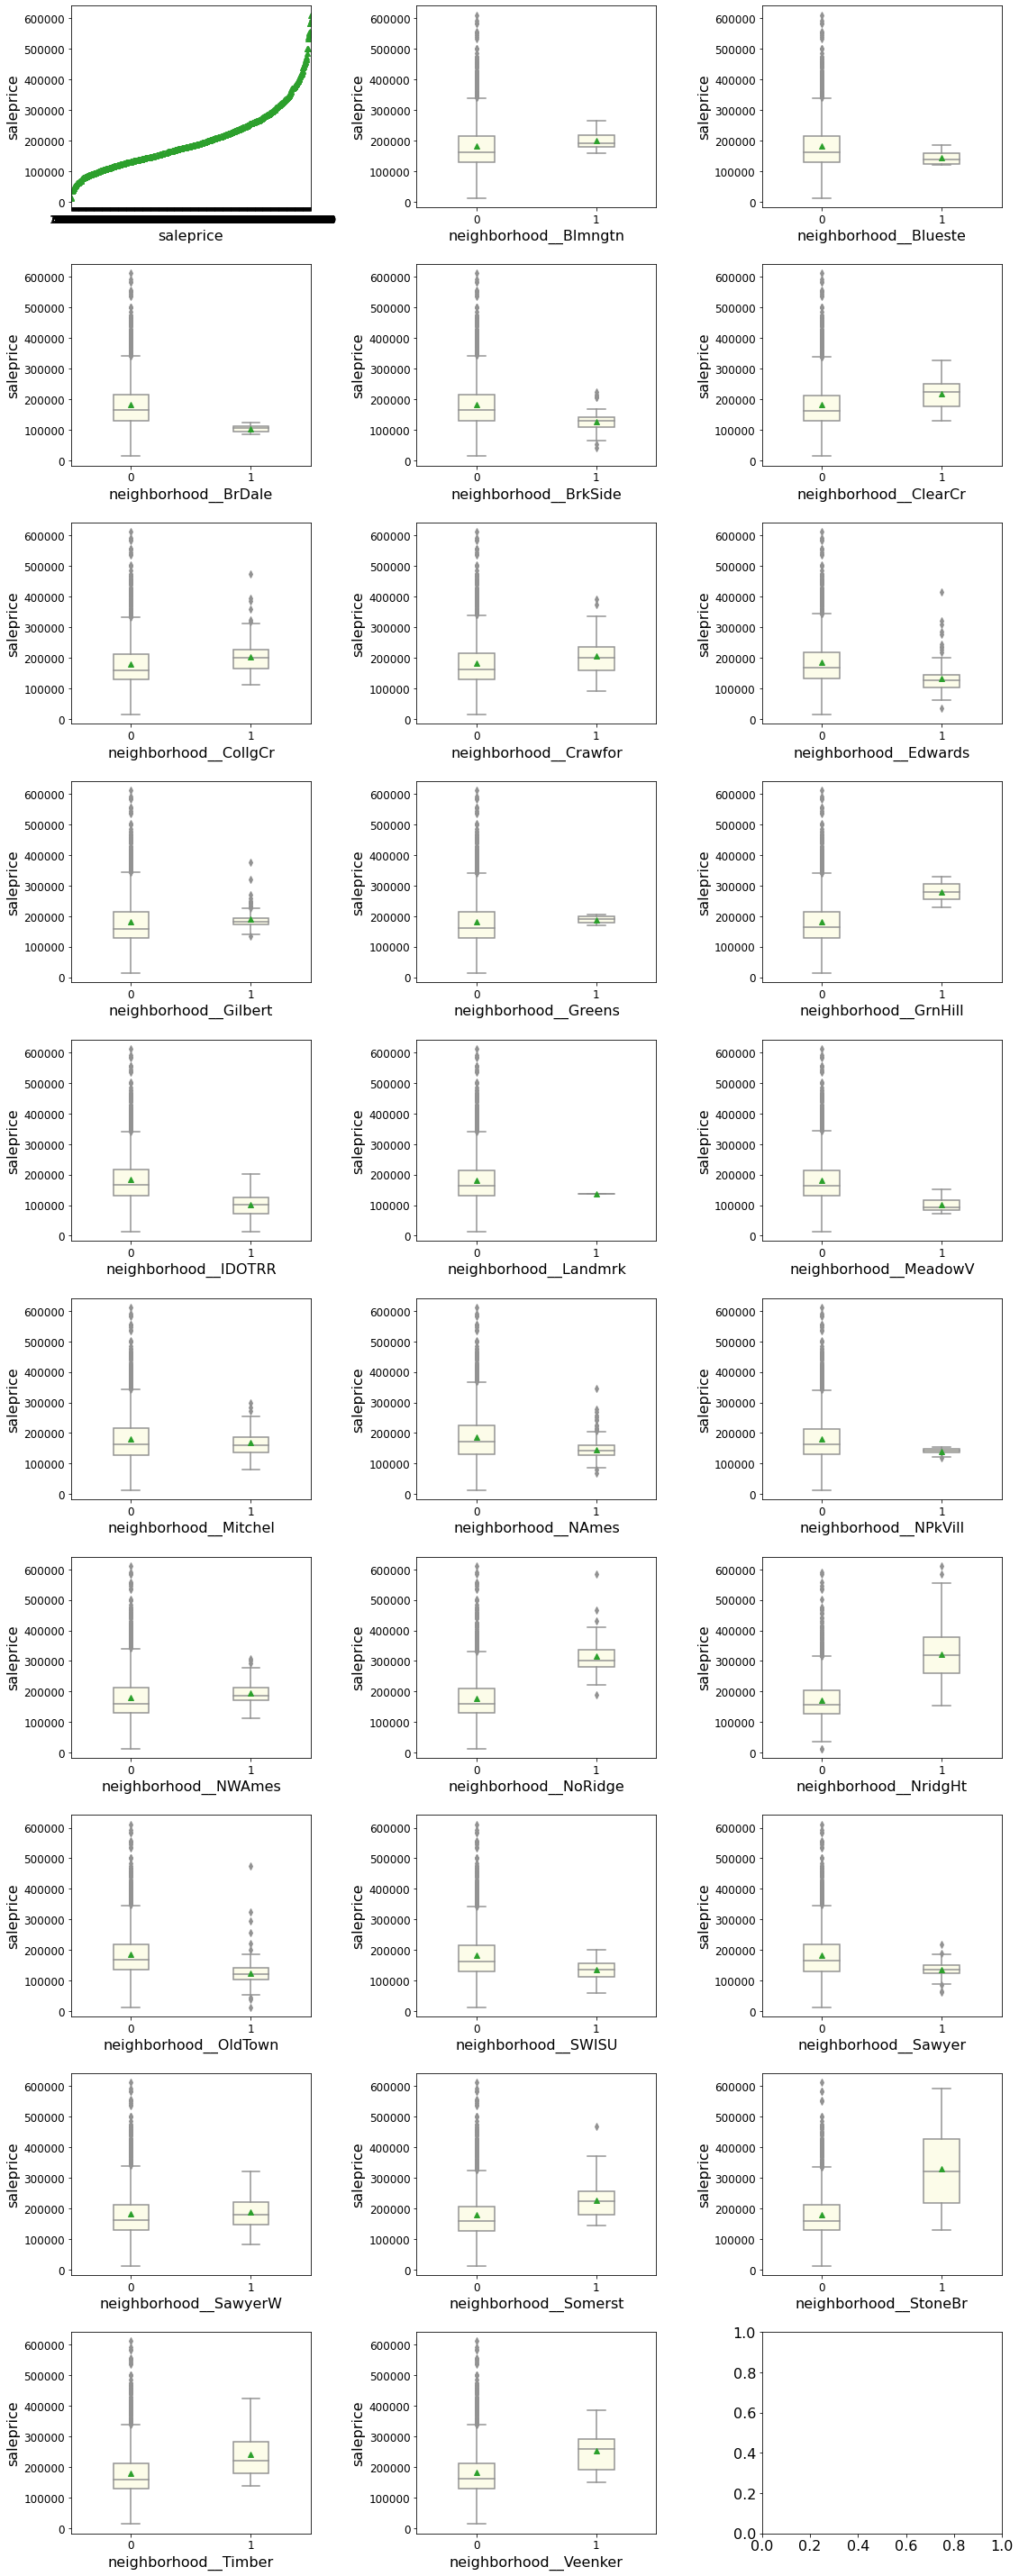

In [20]:
# explore neighborhoods in detail
neighborhood = pd.get_dummies(df_train, prefix_sep='__', columns = ['neighborhood'])
neighborhood_dummies = neighborhood.drop(columns = list_other_col)
neighborhood_dummies_col = list(neighborhood_dummies.columns)

draw_boxplots(neighborhood_dummies, neighborhood_dummies_col)

**Out of the `list_neighborhood_dummies` (value counts > 100), we see from the boxplots (from generated dummies) that:**
- While `neighborhood__NAmes`, `neighborhood__Gilbert` & `neighborhood__CollgCr` has high value count, it is not too far off from the mean / median of the rest of data;


- `neighborhood__OldTown`, `neighborhood__Sawyer` & `neighborhood__Edwards` on the other hand seem to be "cheaper" districts on average (note: these also happen to carry more outliers), and


- `neighborhood__NridgHt` & `neighborhood__Somerst` appear to be a more expensive district on average.


- Interestingly, while most categories have some number of outliers, we don't see medians and means varying too much from one another. Opt not to remove outliers.


In [21]:
# log list of neighborhood dummy features to be in final feature list

list_neighborhood_dummy_features = [
    'neighborhood__OldTown',
    'neighborhood__Edwards',
    'neighborhood__Somerst',
    'neighborhood__NridgHt',
    'neighborhood__Sawyer'
]

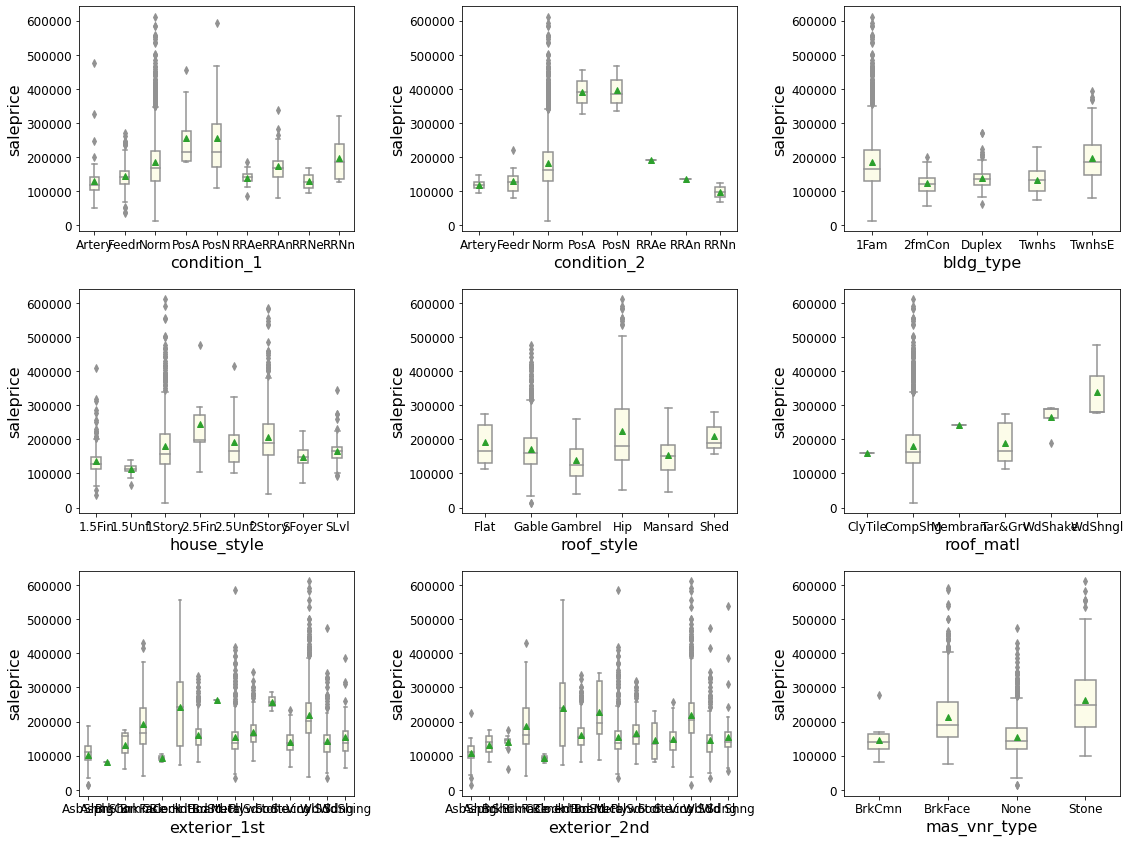

In [22]:
draw_boxplots(df_train, list_categorical[9:18])

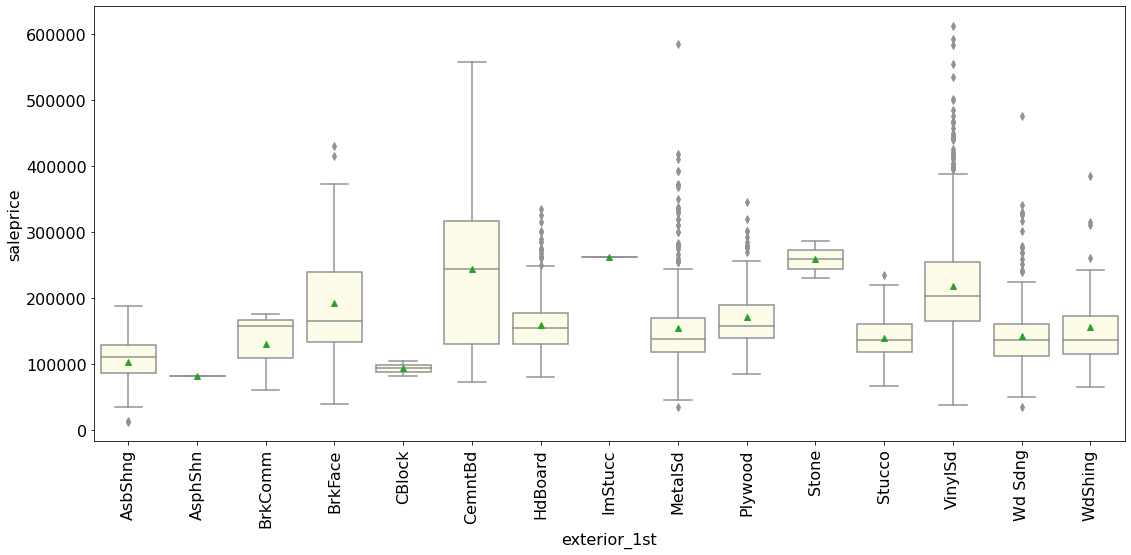

In [23]:
draw_boxplots_dive(df_train, 'exterior_1st')

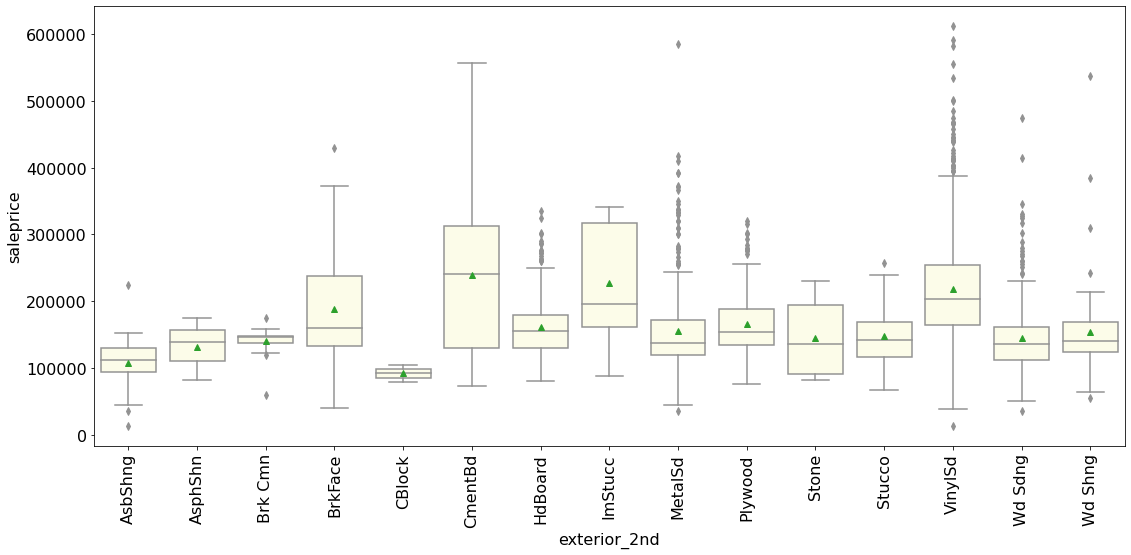

In [24]:
draw_boxplots_dive(df_train, 'exterior_2nd')

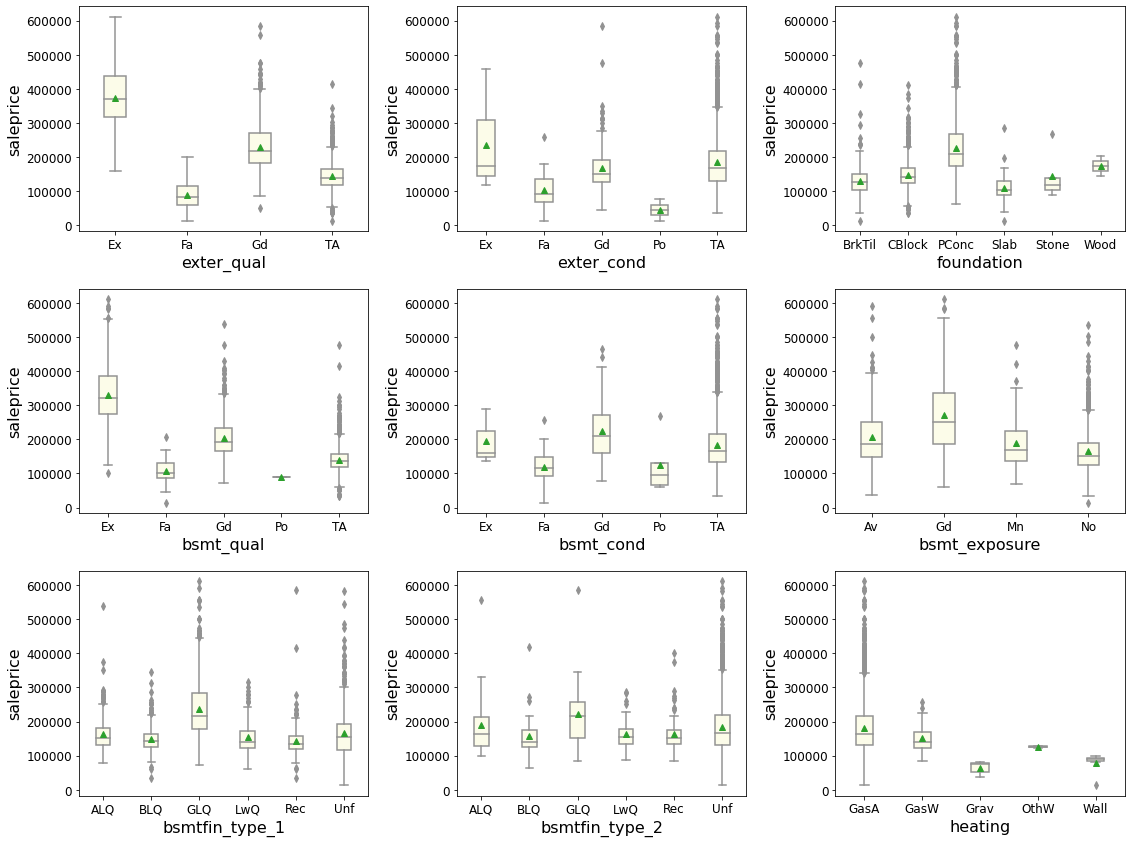

In [25]:
draw_boxplots(df_train, list_categorical[18:27])

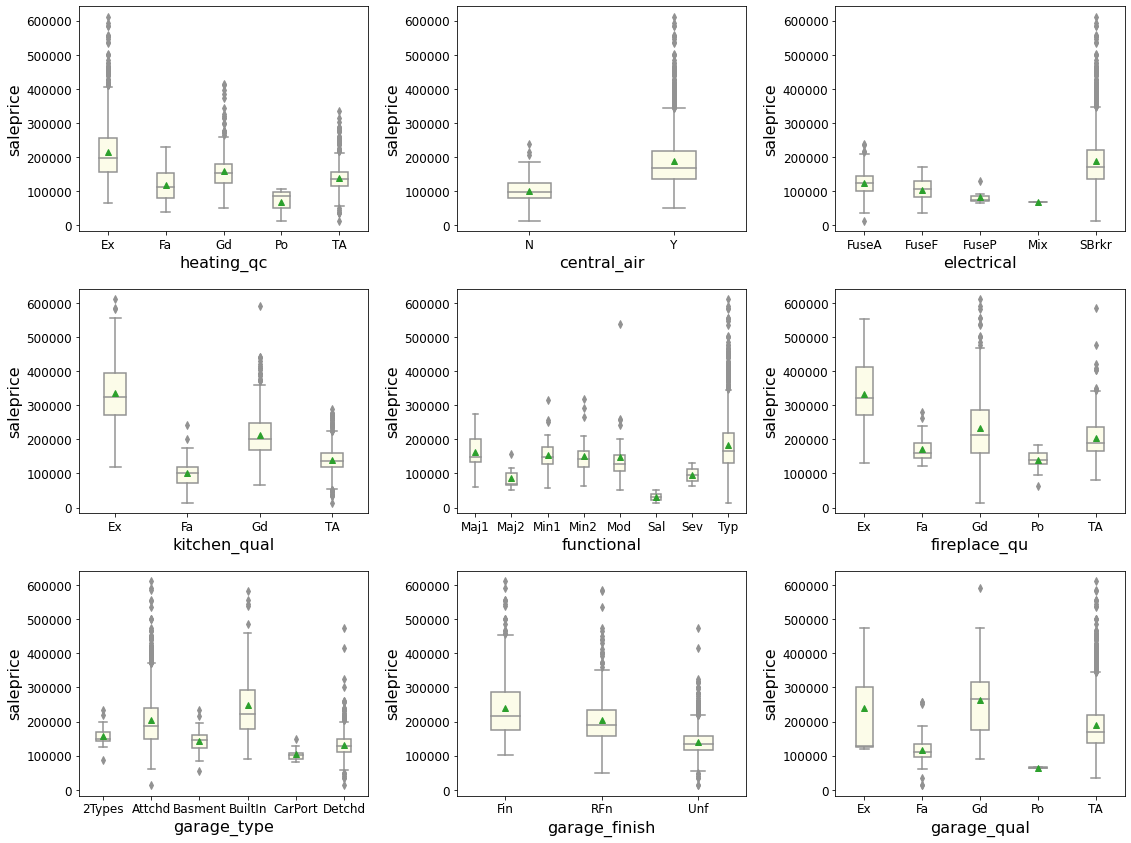

In [26]:
draw_boxplots(df_train, list_categorical[27:36])

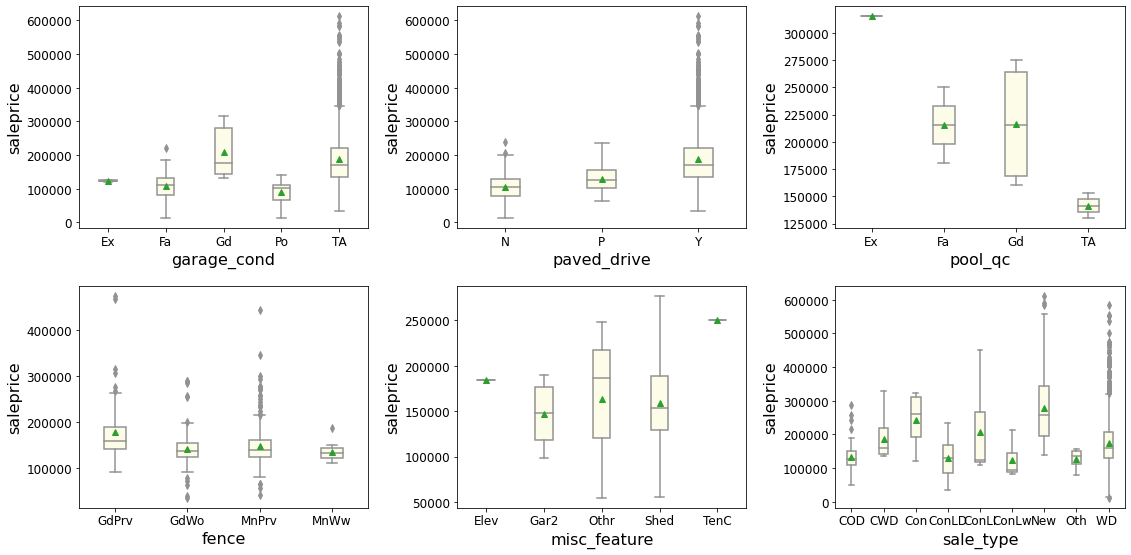

In [27]:
draw_boxplots(df_train, list_categorical[36:])

[Back to contents](#Content)

#### Visualizing numerical variables

In the first 3 x 3 grid of scatter subplots, we already see a few cases of variables that are clearly more suited to be categorical, and also variables exhibiting heteroscedasticity.

We will form lists of these variables to log these issues:
- `list_missed_categorical` : log potentially misclassified categorical variables
- `list_scatter_drop` : log variables with low predictive value to consider dropping
- `list_heteros` : log variables exhibiting heteroscedasticity

**Once a variable is logged in `list_scatter_drop`, we will not log this in `list_heteros` as we plan not to use this variable as a numerical feature.**

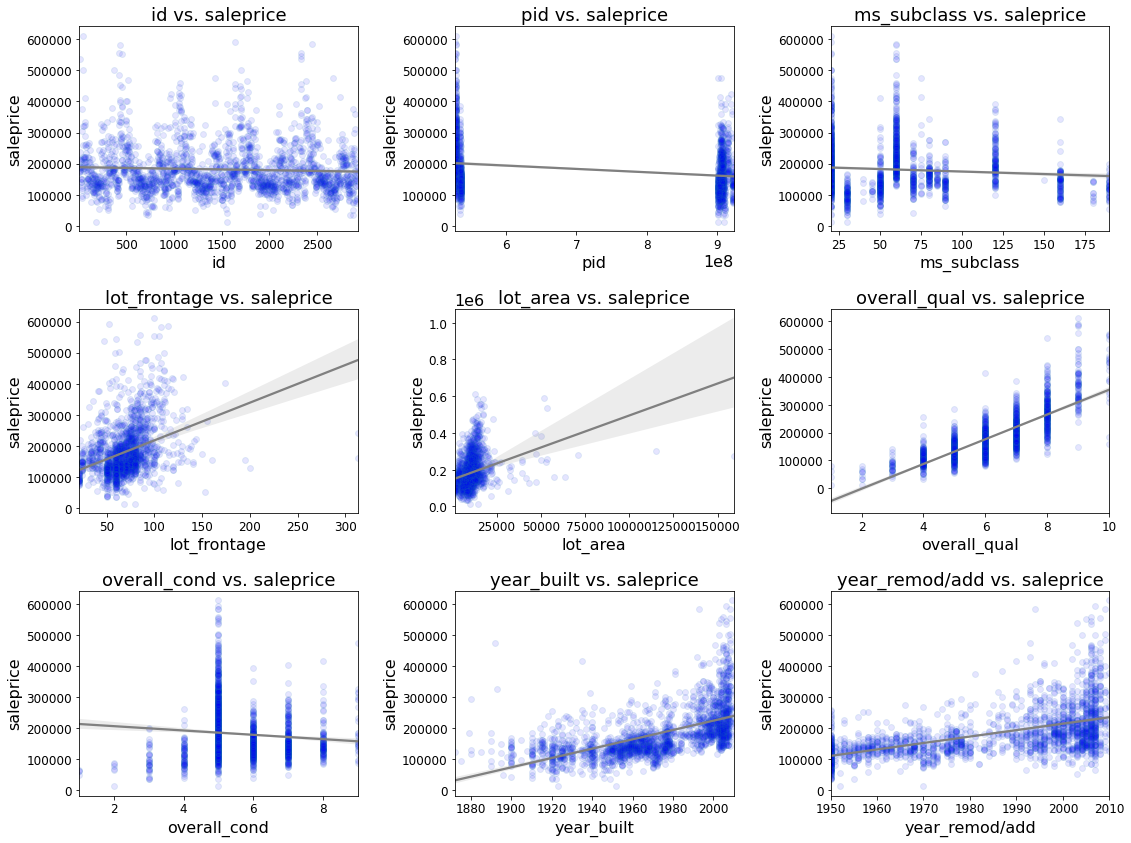

In [28]:
# Scatter subplots for remaining int / float columns

# Assume int/float columns are numerical
df_train_numerical = df_train.select_dtypes(include = ['int64', 'float64']).columns

# Scatter subplot 1
draw_subplot_scatter(df_train, df_train_numerical[:9])

In [29]:
# Log for scatter subplot 1 

list_missed_categorical = ['ms_subclass', 'overall_qual', 'overall_cond']

list_scatter_drop = []

list_heteros = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1']

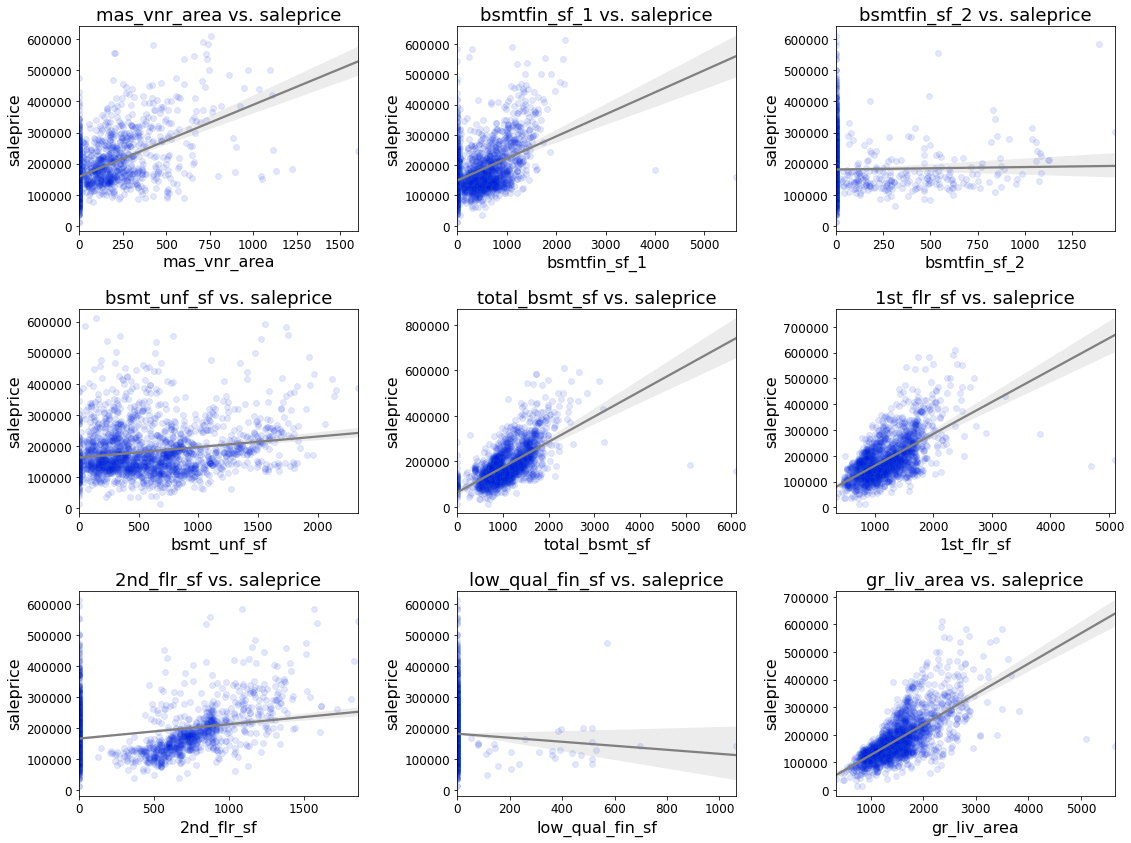

In [30]:
# Scatter subplot 2
draw_subplot_scatter(df_train, df_train_numerical[9:18])

In [31]:
# Log for scatter subplot 2
# Continue to log items; choose to define manually rather than append
# which makes it easier to see potential relationships across variables

list_missed_categorical = [
    'ms_subclass', 'overall_qual', 'overall_cond',
    'bsmt_full_bath', 'bsmt_half_bath'
]

list_scatter_drop = [
    'bsmtfin_sf_2'  # subplot 2
]

list_heteros = [
    'lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1',
    'total_bsmt_sf', '1st_flr_sf', 'low_qual_fin_sf', 'gr_liv_area'
]

We see that some of the heteroscedasticity occurring due to zero values (which we saw in the earlier display of the data). This is clear from blue scatter in the scatter plots on the y-axis, for example in `low_qual_fin_sf`.

We also see some of these variables have similar prefixes / suffixes, like `overall_` or `_bath`.

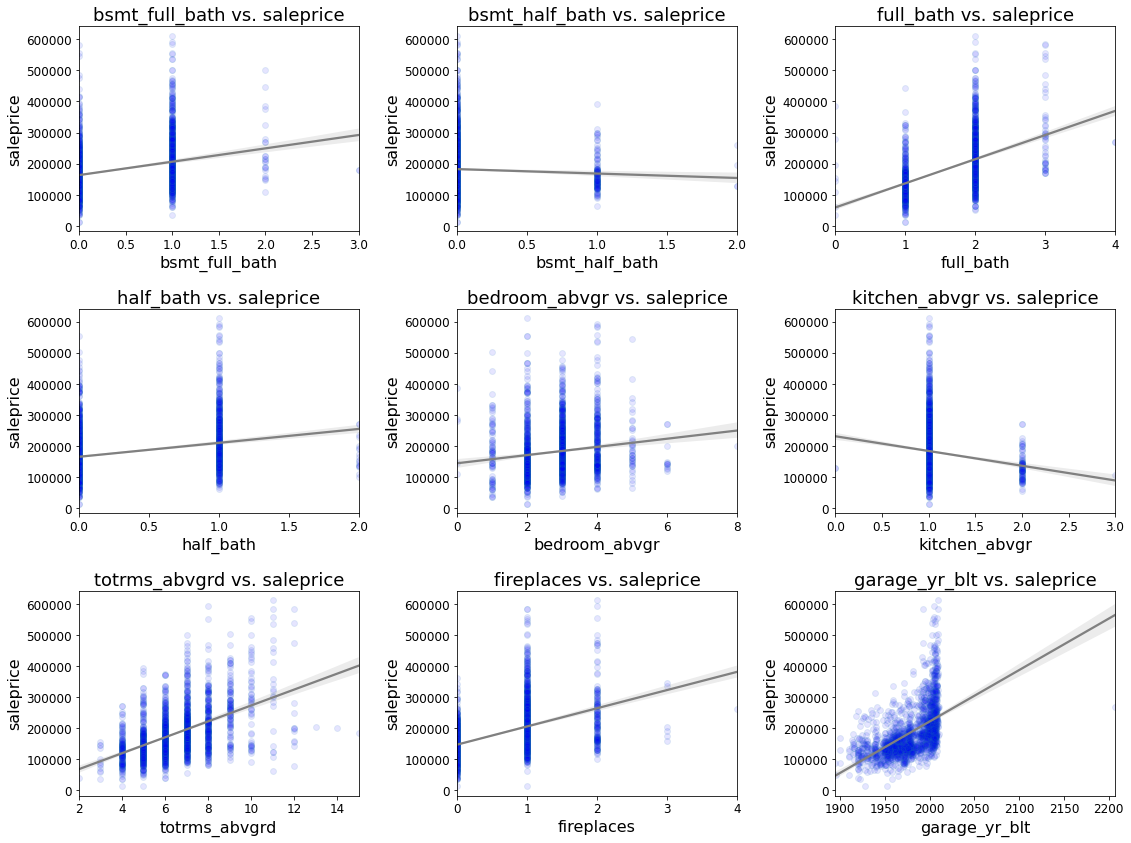

In [32]:
# Scatter subplot 3
draw_subplot_scatter(df_train, df_train_numerical[18:27])

In [33]:
# Log for scatter subplot 3
# Continue to log items; choose to define manually rather than append
# which makes it easier to see potential relationships across variables

list_missed_categorical = [
    'ms_subclass', 'overall_qual', 'overall_cond',
    'bsmt_full_bath', 'bsmt_half_bath',
    'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', # subplot 3
    'totrms_abvgrd', 'fireplaces', 'garage_cars'                # subplot 3
]

list_scatter_drop = [
    'bsmtfin_sf_2'  # subplot 2, none for subplot 1 and 3
]

list_heteros = [
    'lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1',
    'bsmt_sf_2', 'total_bsmt_sf', '1st_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
    'totrms_abvgrd', 'garage_yr_blt'
]

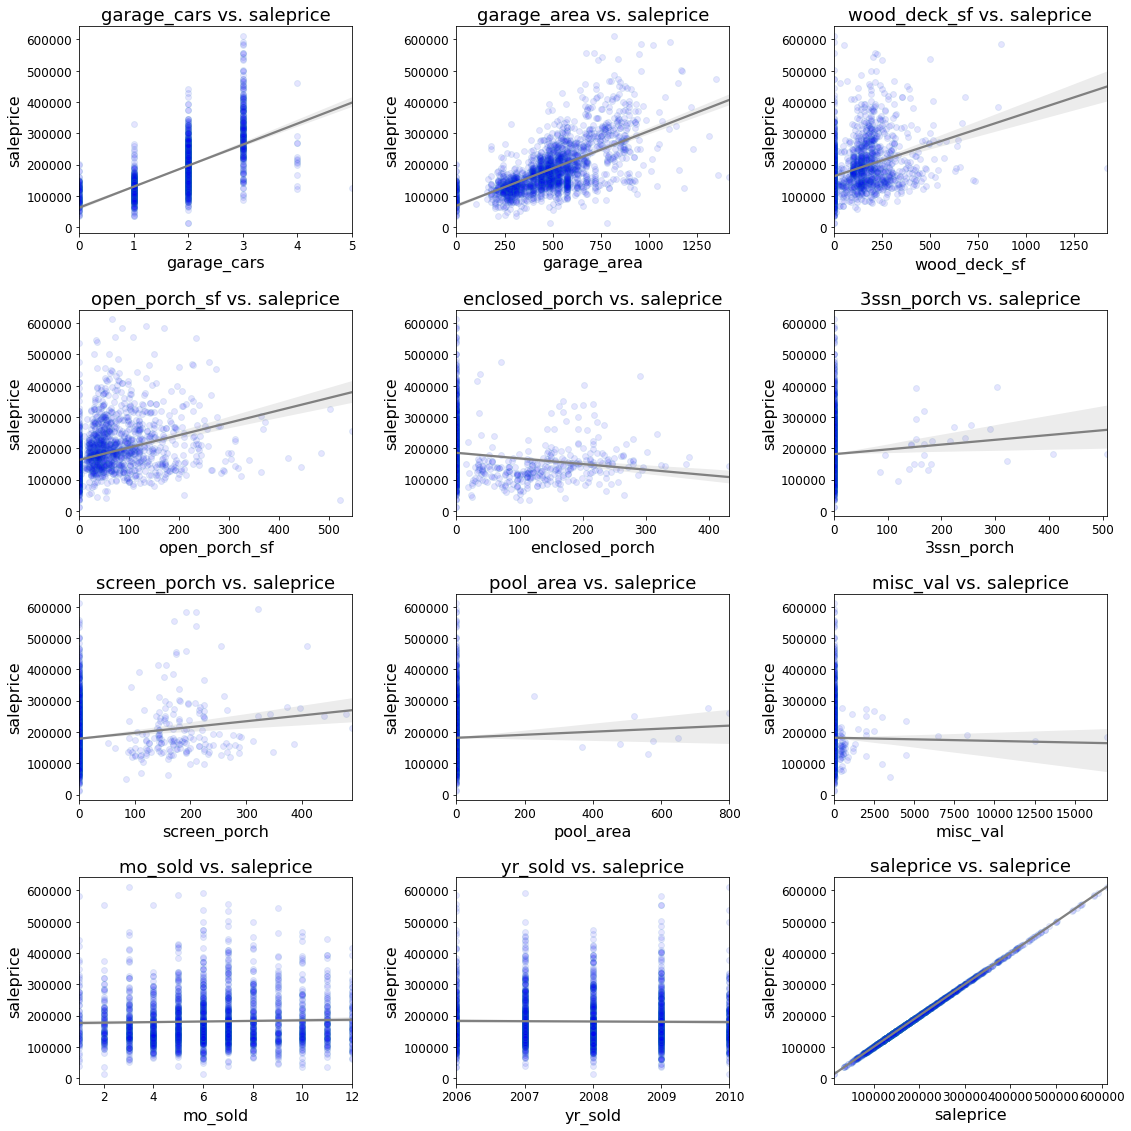

In [34]:
# Scatter subplot 4
draw_subplot_scatter(df_train, df_train_numerical[27:])

In [35]:
# Log for scatter subplot 4
# Continue to log items; choose to define manually rather than append
# which makes it easier to see potential relationships across variables

list_missed_categorical = [
    'ms_subclass', 'overall_qual', 'overall_cond',
    'bsmt_full_bath', 'bsmt_half_bath',
    'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', # subplot 3
    'totrms_abvgrd', 'fireplaces', 'garage_cars'               # subplot 3
]

list_scatter_drop = [
    'bsmtfin_sf_2',  # subplot 2, none for subplot 1 and 3
    'pool_area', 'misc_val', 'mo_sold', 'yr_sold'
]

list_heteros = [
    'lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1',
    'bsmt_sf_2', 'total_bsmt_sf', '1st_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
    'totrms_abvgrd', 'garage_yr_blt',
    'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',  # subplot 4
    'screen_porch'                                                    # subplot 4
]

As we review the data, the intuition that some potentially "missed categorical" variables may be better left as numerical.

For example, number of bathrooms and number of fireplaces can be positively correlated with `saleprice` becomes more apparent. Their predictive value to the model can be assessed in a correlation matrix later.

However, nominal variables and ordinal variables that are survey / based should be reclassified. In these cases, order / ranking has less meaning.

In [36]:
# Update list_missed_categorical
list_missed_categorical = [
    'ms_subclass', 'overall_qual', 'overall_cond'
]

A number of scatterplots show low predictive value (almost straight lines).
We should consider dropping these variables rather than performing tedious transformations to clean them.

For date-time variables (e.g. `mo_sold`) which arguably may join the "missed categorical" list in this subplot, choose to drop these since they do not exhibit much correlation / predictive value as regards to `saleprice`.

In [37]:
# Typecasting as category for list_missed_categorical
df_train[list_missed_categorical] = df_train[list_missed_categorical].astype('category')

# Re-defining df_train_numerical
df_train_numerical = df_train.select_dtypes(include = ['int64', 'float64']).columns

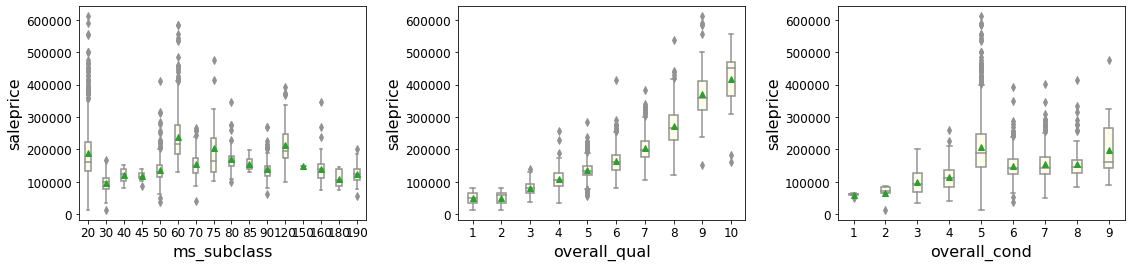

In [38]:
# Boxplots for list_missed_categorical
draw_boxplots(df_train, list_missed_categorical)

[Back to contents](#Content)

### Correlation heatmaps and feature engineering

Heatmaps plotted below to get a feel of correlations between variables. This will also help with preliminary feature selection. Correlation allows some assessment of the degree to which feature may explain `saleprice`. It also helps to identify multicollinearity.

Relevant dummy variables are also created and explored as viable features for the model.

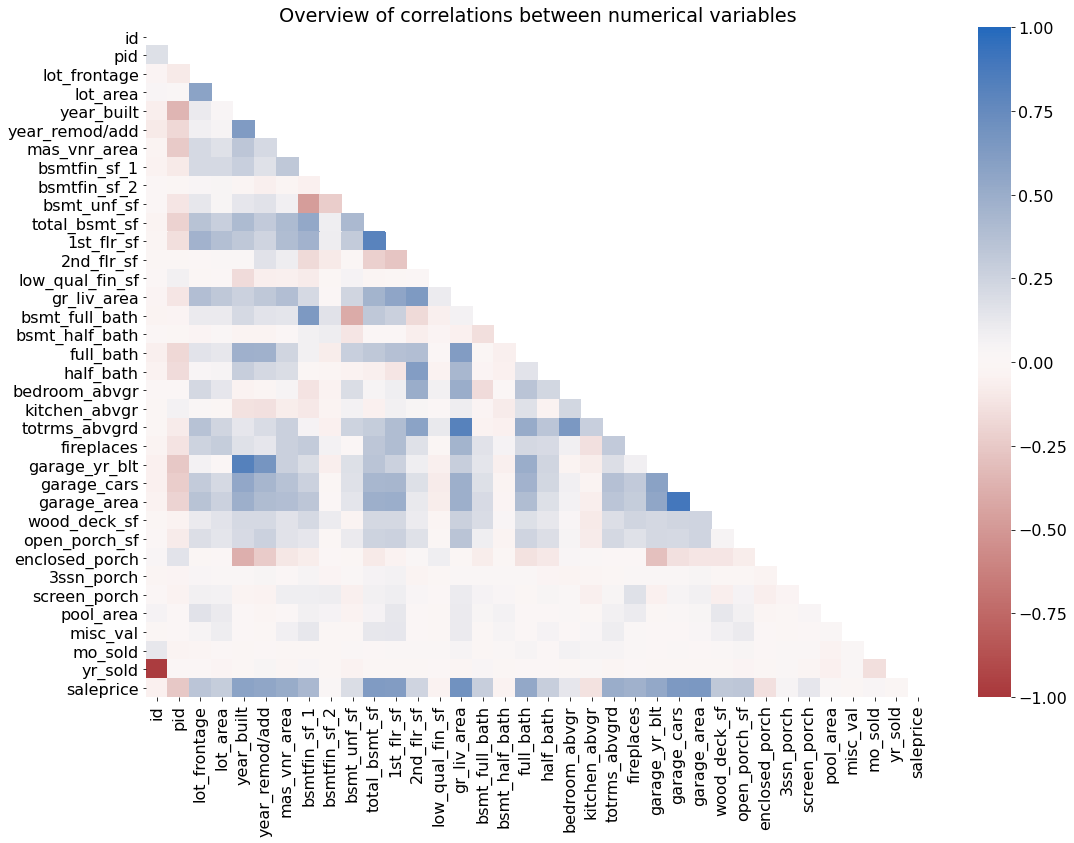

In [39]:
# Numerical variables heatmap

plt.figure(figsize = (16,12))

sns.heatmap(df_train[df_train_numerical].corr(),
            cmap = 'vlag_r', 
            vmin = -1,
            vmax = 1,
#             annot_kws = {'size' : 10},
            mask = np.triu(np.ones_like(df_train[df_train_numerical].corr(), dtype=bool))
           )

plt.title('Overview of correlations between numerical variables')
plt.tight_layout()

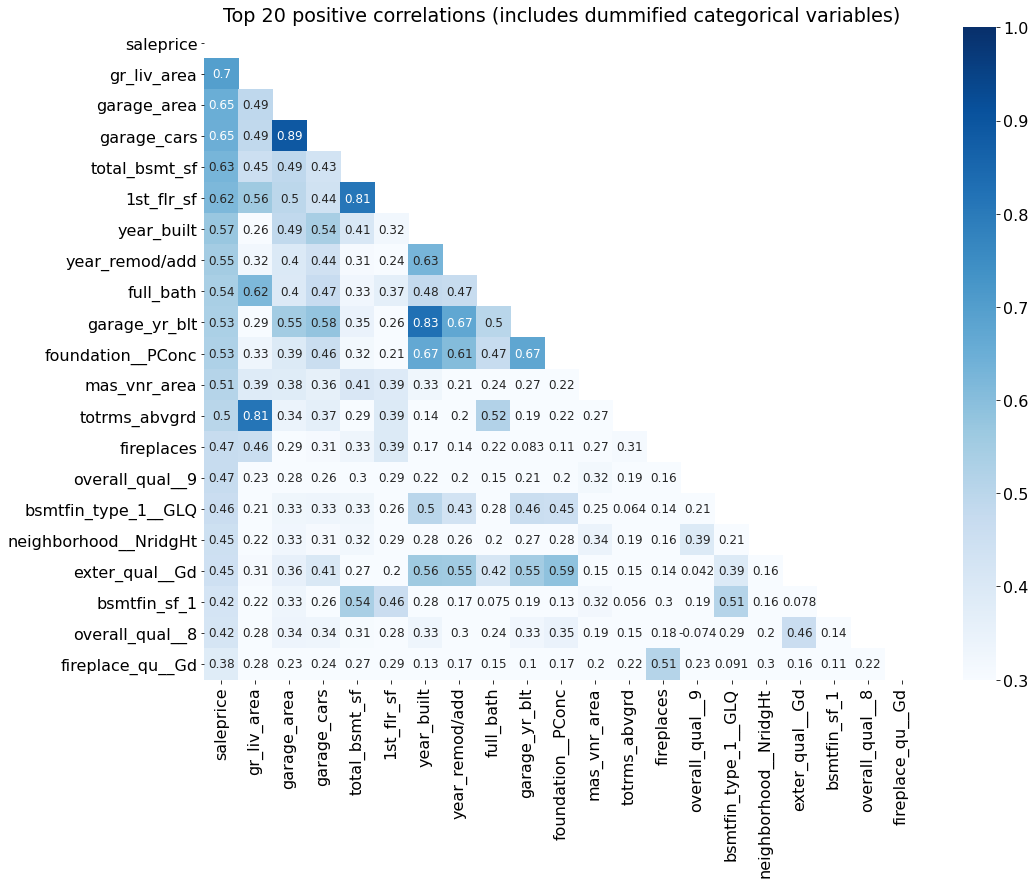

In [40]:
# Top 20 features including categorical variables (positive correlation)

# set up dummies
df_train_dummies = pd.get_dummies(df_train, prefix_sep = '__', drop_first = True)

top_20_corr = df_train_dummies.corr().nlargest(21, 'saleprice').index

plt.figure(figsize = (16,12))

# coloring and vmin was changed since we expect ranking by top (positive) correlations
# vmin used as threshold
sns.heatmap(df_train_dummies[top_20_corr].corr(),
            cmap = 'Blues', 
            vmin = 0.3,
            vmax = 1,
            annot = True,
            annot_kws = {'size' : 12},
            mask = np.triu(np.ones_like(df_train_dummies[top_20_corr].corr(), dtype=bool))
           )

plt.title('Top 20 positive correlations (includes dummified categorical variables)');

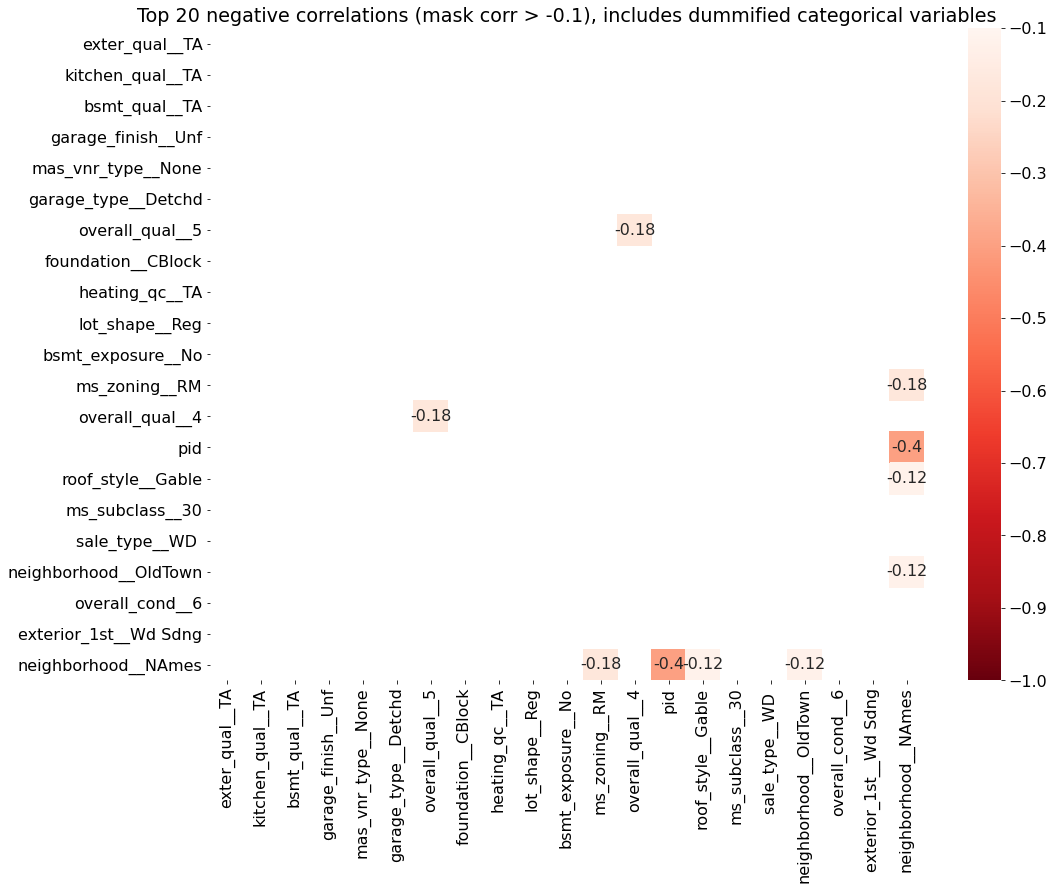

In [41]:
 # Top 20 features including categorical variables (negative correlation)

# set up dummies (already done above)
# df_train_dummies = pd.get_dummies(df_train, drop_first = True)

top_20_corr_negative = df_train_dummies.corr().nsmallest(21, 'saleprice').index

plt.figure(figsize = (16,12))

# coloring and vmin / vmiax changed
sns.heatmap(df_train_dummies[top_20_corr_negative].corr(),
            cmap = 'Reds_r', 
            vmin = -1,
            vmax = -0.1,
            annot = True,
            mask = (df_train_dummies[top_20_corr_negative].corr() > -0.1)
           )

plt.title('Top 20 negative correlations (mask corr > -0.1), includes dummified categorical variables');

Almost no significantly negative correlations exist; we can disregard most of these variables.
We may perform preliminary feature selection from `top_20_corr` list, noting we should address multicollinearity.

#### Heatmap to assess multi-collinearity

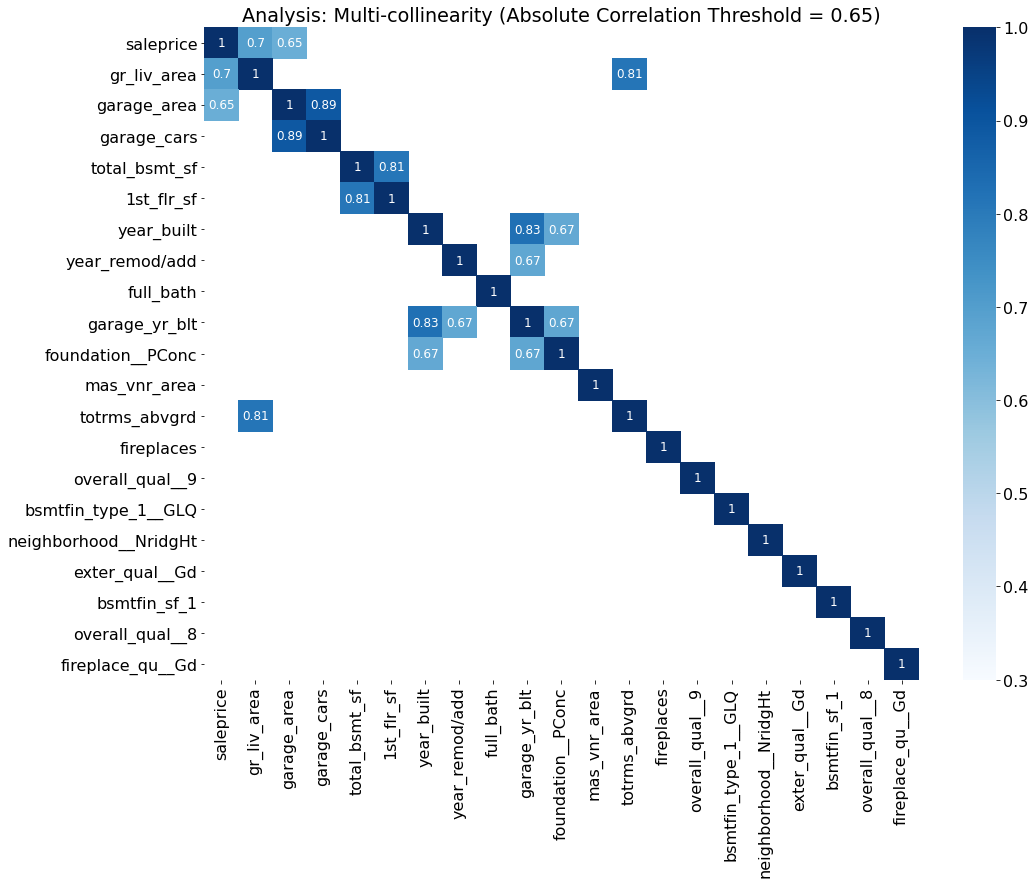

In [42]:
# Take 0.65 as absolute threshold to identify multicollinearity in features

plt.figure(figsize = (16,12))

sns.heatmap(df_train_dummies[top_20_corr].corr(),
            cmap = 'Blues', 
            vmin = 0.3,
            vmax = 1,
            annot = True,
            annot_kws = {'size' : 12},
            mask = (df_train_dummies[top_20_corr].corr() <= 0.65)
           )

plt.title('Analysis: Multi-collinearity (Absolute Correlation Threshold = 0.65)');

Looking only into correlations between supposedly independent variables, we see a number of variables highly correlated with one another (taking 0.65 as an absolute threshold).

Identified groupings are:
- `gr_live_area` and `totrms_abvgrd`,
- `garage_area` and `garage_cars`,
- `total_bsmt_sf` and `1st_flr_sf`,
- `year_built` and `garage_yr_blt`, and
- `year_built`, `year_remod/add`,`garage_yr_blt` and `foundation__PConc` (dummy).

To avoid multicollinearity in our model, we can drop / avoid selecting:
- `foundation__PConc`,
- `year_remod/add`,
- `garage_yr_blt`,
- `1st_flr_sf`,
- `garage_cars`, and
- `totrms_abvgrd`.

In [43]:
# list of items to remove from top 20
list_remove = [
    'foundation__PConc', 'year_remod/add', 'garage_yr_blt', '1st_flr_sf',
    'garage_cars', 'totrms_abvgrd'
]

[Back to contents](#Content)

### More Pre-processing

In [44]:
# define features list; this will still include saleprice
list_features = list(top_20_corr)

# remove from multicollinearity
list_features = [features for features in list_features if features not in list_remove]

# add neighborhood dummy features from boxplot analysis without duplicates
list_features = list(set(list_features + list_neighborhood_dummy_features))

# remove saleprice
list_features_only = [features for features in list_features if features not in 'saleprice']

In [45]:
list_features

['saleprice',
 'mas_vnr_area',
 'overall_qual__8',
 'total_bsmt_sf',
 'neighborhood__Sawyer',
 'overall_qual__9',
 'gr_liv_area',
 'neighborhood__NridgHt',
 'exter_qual__Gd',
 'neighborhood__Somerst',
 'bsmtfin_type_1__GLQ',
 'bsmtfin_sf_1',
 'fireplace_qu__Gd',
 'fireplaces',
 'neighborhood__OldTown',
 'neighborhood__Edwards',
 'year_built',
 'full_bath',
 'garage_area']

In [46]:
list_features_only

['mas_vnr_area',
 'overall_qual__8',
 'total_bsmt_sf',
 'neighborhood__Sawyer',
 'overall_qual__9',
 'gr_liv_area',
 'neighborhood__NridgHt',
 'exter_qual__Gd',
 'neighborhood__Somerst',
 'bsmtfin_type_1__GLQ',
 'bsmtfin_sf_1',
 'fireplace_qu__Gd',
 'fireplaces',
 'neighborhood__OldTown',
 'neighborhood__Edwards',
 'year_built',
 'full_bath',
 'garage_area']

[Back to contents](#Content)

In [47]:
# Set up dataframe
df_train_clean = df_train_dummies[list_features]
df_train_clean.sample(n = 10).T

,1529,1897,470,716,271,1154,193,614,826,1307
saleprice,157000.0,415000.0,154000.0,153000.0,149900.0,120500.0,152000.0,160000.0,124000.0,107000.0
mas_vnr_area,0.0,0.0,0.0,40.0,0.0,0.0,189.0,51.0,0.0,0.0
overall_qual__8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
total_bsmt_sf,1073.0,1836.0,1246.0,450.0,833.0,864.0,1090.0,995.0,1046.0,686.0
neighborhood__Sawyer,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
overall_qual__9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gr_liv_area,1073.0,3672.0,1246.0,1034.0,833.0,864.0,1370.0,1009.0,1054.0,1328.0
neighborhood__NridgHt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
exter_qual__Gd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
neighborhood__Somerst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# check for nulls
df_train_clean.isnull().sum()

saleprice                 0
mas_vnr_area             22
overall_qual__8           0
total_bsmt_sf             1
neighborhood__Sawyer      0
overall_qual__9           0
gr_liv_area               0
neighborhood__NridgHt     0
exter_qual__Gd            0
neighborhood__Somerst     0
bsmtfin_type_1__GLQ       0
bsmtfin_sf_1              1
fireplace_qu__Gd          0
fireplaces                0
neighborhood__OldTown     0
neighborhood__Edwards     0
year_built                0
full_bath                 0
garage_area               1
dtype: int64

#### Display more information [(similar to earlier display)](#Display-more-information)

In [49]:
for col in df_train_clean[list_features]:
    show_more_info(df_train_clean, col)

----- saleprice -----


130000.0    25
140000.0    22
145000.0    20
135000.0    19
170000.0    16
            ..
342000.0     1
248500.0     1
212900.0     1
62500.0      1
336860.0     1
Name: saleprice, Length: 828, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- mas_vnr_area -----


0.0      1216
120.0      11
176.0      10
200.0      10
210.0       9
         ... 
576.0       1
796.0       1
573.0       1
372.0       1
428.0       1
Name: mas_vnr_area, Length: 373, dtype: int64

'Percentage of null_counts: 1.0726474890297415%'

'Percentage of zero_counts: 59.28815212091663%'

----- overall_qual__8 -----


0    1801
1     250
Name: overall_qual__8, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 87.8108239882984%'

----- total_bsmt_sf -----


0.0       54
864.0     51
1040.0    20
672.0     20
816.0     17
          ..
1129.0     1
946.0      1
1236.0     1
2220.0     1
973.0      1
Name: total_bsmt_sf, Length: 892, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 2.6328620185275478%'

----- neighborhood__Sawyer -----


0    1940
1     111
Name: neighborhood__Sawyer, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 94.58800585080449%'

----- overall_qual__9 -----


0    1974
1      77
Name: overall_qual__9, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 96.24573378839591%'

----- gr_liv_area -----


864     25
1040    20
1092    19
1200    16
1456    15
        ..
1894     1
1898     1
2057     1
1908     1
2037     1
Name: gr_liv_area, Length: 1053, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- neighborhood__NridgHt -----


0    1929
1     122
Name: neighborhood__NridgHt, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 94.05168210628962%'

----- exter_qual__Gd -----


0    1354
1     697
Name: exter_qual__Gd, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 66.01657727937591%'

----- neighborhood__Somerst -----


0    1921
1     130
Name: neighborhood__Somerst, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 93.66162847391516%'

----- bsmtfin_type_1__GLQ -----


0    1436
1     615
Name: bsmtfin_type_1__GLQ, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 70.01462701121403%'

----- bsmtfin_sf_1 -----


0.0       657
24.0       17
16.0       10
20.0        7
384.0       7
         ... 
718.0       1
900.0       1
918.0       1
1619.0      1
1159.0      1
Name: bsmtfin_sf_1, Length: 821, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 32.03315455875183%'

----- fireplace_qu__Gd -----


0    1528
1     523
Name: fireplace_qu__Gd, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 74.50024378352023%'

----- fireplaces -----


0    1000
1     898
2     146
3       6
4       1
Name: fireplaces, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 48.75670404680644%'

----- neighborhood__OldTown -----


0    1888
1     163
Name: neighborhood__OldTown, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 92.05265724037055%'

----- neighborhood__Edwards -----


0    1908
1     143
Name: neighborhood__Edwards, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 93.02779132130668%'

----- year_built -----


2005    102
2006     99
2007     78
2004     72
2003     64
       ... 
1898      1
1896      1
1892      1
1875      1
1872      1
Name: year_built, Length: 113, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.0%'

----- full_bath -----


2    1096
1     900
3      45
0       8
4       2
Name: full_bath, dtype: int64

'Percentage of null_counts: 0.0%'

'Percentage of zero_counts: 0.39005363237445145%'

----- garage_area -----


0.0       113
440.0      70
576.0      69
484.0      52
528.0      46
         ... 
808.0       1
752.0       1
858.0       1
422.0       1
1174.0      1
Name: garage_area, Length: 514, dtype: int64

'Percentage of null_counts: 0.04875670404680643%'

'Percentage of zero_counts: 5.509507557289127%'

In [50]:
# On review of info, the null values are really zero values, hence fillna(value=0.0)
df_train_clean = df_train_clean.fillna(value=0.0)

In [51]:
# view columns with nulls
df_train_clean.isnull().sum().sum()

0

In [52]:
# list of heteroscedastic variables to clean
list_het_to_clean = [elem for elem in list_features if elem in list_heteros]
list_het_to_clean

['mas_vnr_area', 'total_bsmt_sf', 'gr_liv_area', 'bsmtfin_sf_1']

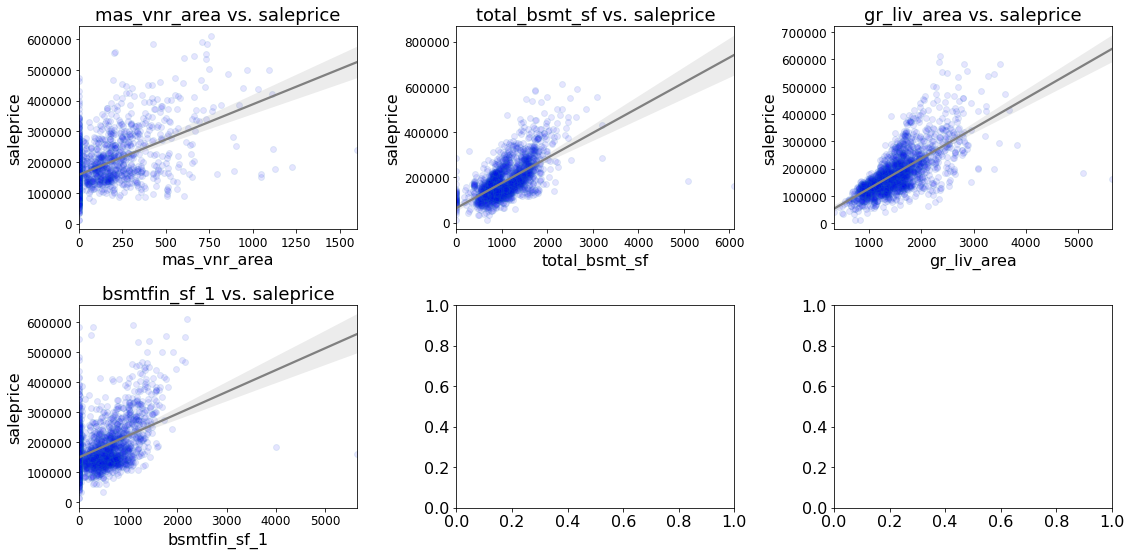

In [53]:
# visualize heteroscedasticity issues remaining
draw_subplot_scatter(df_train_clean, list_het_to_clean)

If we examine the manner in which heteroskedasticity appears in these variables, it seems to be generated more by outliers and concentrations of zero values (especially for `mas_vnr_area` which has ~60% zero values).

Treat with log(x+1) transformation.

In [54]:
# review summary stats before transformation
df_train_clean[list_het_to_clean].describe()

,mas_vnr_area,total_bsmt_sf,gr_liv_area,bsmtfin_sf_1
count,2051.000000,2051.000000,2051.000000,2051.000000
mean,98.626524,1057.471965,1499.330083,442.084837
std,174.324690,449.908003,500.447829,461.195041
min,0.000000,0.000000,334.000000,0.000000
25%,0.000000,793.000000,1129.000000,0.000000
50%,0.000000,994.000000,1444.000000,368.000000
75%,159.000000,1318.500000,1728.500000,733.500000
max,1600.000000,6110.000000,5642.000000,5644.000000


#### Using log(x+1) transformation to address heteroscedasticity & high zero-counts

In [55]:
# log(x+1) transformation for identified variables

def logx1_transform(df, col_to_transform):
    for col in col_to_transform:
        df[col] = np.log1p(df[col])
        
logx1_transform(df_train_clean, list_het_to_clean)

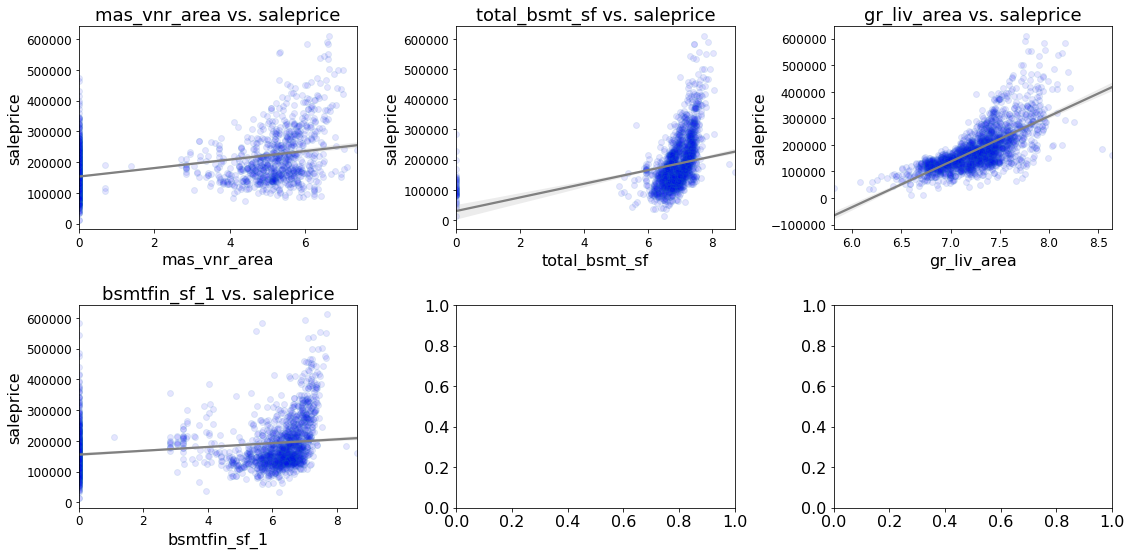

In [56]:
# visualize features after log(x+1) transformation
draw_subplot_scatter(df_train_clean, list_het_to_clean)

In [57]:
# review summary stats after transformation
df_train_clean[list_het_to_clean].describe()

,mas_vnr_area,total_bsmt_sf,gr_liv_area,bsmtfin_sf_1
count,2051.000000,2051.000000,2051.000000,2051.000000
mean,2.064448,6.736552,7.261624,4.211585
std,2.607031,1.179431,0.321547,2.989392
min,0.000000,0.000000,5.814131,0.000000
25%,0.000000,6.677083,7.029973,0.000000
50%,0.000000,6.902743,7.275865,5.910797
75%,5.075154,7.185008,7.455588,6.599190
max,7.378384,8.717846,8.638171,8.638525


[Back to contents](#Content)

### Modelling

#### Dummy baseline model

In [58]:
# Training data: train_test_split
X = df_train_clean[list_features_only]
y = df_train_clean['saleprice']

X_train, X_train_test, y_train, y_train_test = train_test_split(X, y, 
                                                                test_size=0.2, 
                                                                random_state=42,
                                                               )

In [59]:
# Instantiate
dummyreg = DummyRegressor()

# Fit
dummyreg.fit(X_train, y_train)

DummyRegressor()

In [60]:
# Cross validation score
cross_val_score(dummyreg, X_train_test, y_train_test, cv=5).mean()
# terrible score...

-0.026303805238380384

#### Set up test dataframe

In [61]:
# Read test data
df_test = pd.read_csv('./datasets/test.csv')

In [62]:
df_test.set_index('Id')

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,527377110,60,RL,80.0,8000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,11,2007,WD
1234,535126140,60,RL,90.0,14670,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,MnPrv,NaN,0,8,2008,WD
1373,904100040,20,RL,55.0,8250,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2008,WD


In [63]:
# Column name transformations: lower case, snake_case
df_test.columns = df_test.columns.str.lower()
df_test.columns = df_test.columns.str.replace(' ', '_')

# Set up test dataframe
df_test_dummies = pd.get_dummies(df_test, prefix_sep = '__', drop_first = True)

# Get missing columns in the training test
missing_cols = set(df_train_clean.columns) - set(df_test_dummies.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test_dummies[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
df_test_clean = df_test_dummies[df_train_clean.columns]
df_test_clean = df_test_dummies[list_features]

# View 
df_test_clean.describe()

,saleprice,mas_vnr_area,overall_qual__8,total_bsmt_sf,neighborhood__Sawyer,overall_qual__9,gr_liv_area,neighborhood__NridgHt,exter_qual__Gd,neighborhood__Somerst,bsmtfin_type_1__GLQ,bsmtfin_sf_1,fireplace_qu__Gd,fireplaces,neighborhood__OldTown,neighborhood__Edwards,year_built,full_bath,garage_area
count,878.0,877.000000,878.0,878.000000,878.000000,878.0,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.00000,878.000000,878.000000,878.000000,878.000000
mean,0.0,106.236032,0.0,1034.357631,0.045558,0.0,1496.914579,0.050114,0.332574,0.059226,0.276765,441.328018,0.250569,0.618451,0.08656,0.056948,1970.492027,1.539863,470.362187
std,0.0,187.158908,0.0,413.446291,0.208644,0.0,506.468967,0.218304,0.471404,0.236181,0.447654,438.457329,0.433588,0.669571,0.28135,0.231875,30.395895,0.559060,212.734075
min,0.0,0.000000,0.0,0.000000,0.000000,0.0,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1880.000000,0.000000,0.000000
25%,0.0,0.000000,0.0,789.000000,0.000000,0.0,1114.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1954.000000,1.000000,322.500000
50%,0.0,0.000000,0.0,975.000000,0.000000,0.0,1436.000000,0.000000,0.000000,0.000000,0.000000,373.000000,0.000000,1.000000,0.00000,0.000000,1972.000000,2.000000,473.000000
75%,0.0,172.000000,0.0,1247.000000,0.000000,0.0,1779.000000,0.000000,1.000000,0.000000,1.000000,734.750000,0.750000,1.000000,0.00000,0.000000,1999.750000,2.000000,576.000000
max,0.0,1378.000000,0.0,2630.000000,1.000000,0.0,4476.000000,1.000000,1.000000,1.000000,1.000000,2288.000000,1.000000,3.000000,1.00000,1.000000,2010.000000,4.000000,1488.000000


In [64]:
# Null values check
df_test_clean.isnull().sum()

saleprice                0
mas_vnr_area             1
overall_qual__8          0
total_bsmt_sf            0
neighborhood__Sawyer     0
overall_qual__9          0
gr_liv_area              0
neighborhood__NridgHt    0
exter_qual__Gd           0
neighborhood__Somerst    0
bsmtfin_type_1__GLQ      0
bsmtfin_sf_1             0
fireplace_qu__Gd         0
fireplaces               0
neighborhood__OldTown    0
neighborhood__Edwards    0
year_built               0
full_bath                0
garage_area              0
dtype: int64

In [65]:
# Review row number
df_test_clean[df_test_clean.isna().any(axis=1)].index

Int64Index([865], dtype='int64')

In [66]:
# Review if there is any masonry vaneer
df_test['mas_vnr_type'].loc[865]

nan

In [67]:
# no masonry vaneer, hence fillna with zero
df_test_clean = df_test_clean.fillna(value = 0)

#### Set up X_test

In [68]:
# set up for X_test
X_test = df_test_clean[list_features_only]

#### Predict for Dummy baseline model

In [69]:
# Predict for dummy baseline model
y_pred_dummyreg = dummyreg.predict(X_test)

In [70]:
# Save to csv
df_dummyreg_1 = pd.DataFrame(
    y_pred_dummyreg,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_dummyreg_1.to_csv('./datasets/dummyreg_1.csv')

In [71]:
df_dummyreg_1.T
# Kaggle score: 83913.20964

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,...,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439,181718.527439


#### Mirror training set transformations on test data set

In [72]:
# log(x+1) transformations
logx1_transform(df_test_clean, list_het_to_clean)

#### Predict for Linear Regression model (no scaling)

In [73]:
# Instantiate
linreg = LinearRegression()

In [74]:
# Fit
linreg.fit(X_train, y_train)

LinearRegression()

In [75]:
# Cross validation score
cross_val_score(linreg, X_train_test, y_train_test, cv=5).mean()

0.79491831738781

In [76]:
# Predict for linreg model (no scaling)
y_pred_linreg_1 = linreg.predict(X_test)

In [77]:
# Save to csv
df_linreg_1 = pd.DataFrame(
    y_pred_linreg_1,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_linreg_1.to_csv('./datasets/linreg_1.csv')

In [78]:
# View transpose
df_linreg_1.T

# Kaggle score: 46917.38981 (excl neighborhood new dummies)
# Kaggle score: 47144.47849 (ver 2 with selected neighborhood dummies)

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,1.713907e+08,1.789923e+08,1.333550e+08,8.780222e+07,1.279882e+08,9.725805e+07,9.822132e+07,1.155487e+08,1.491064e+08,1.170405e+08,...,2.160735e+08,1.458939e+08,1.415584e+08,1.865233e+08,1.282076e+08,1.689993e+08,1.783205e+08,1.093100e+08,7.946810e+07,8.535707e+07


[Back to contents](#Content)

#### Apply scaling

In [79]:
# Apply StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_train_test_scaled = ss.fit_transform(X_train_test)
X_test_scaled = ss.fit_transform(X_test)

In [80]:
# Re-fit
linreg.fit(X_train_scaled, y_train)

# Predict for linreg model (no scaling)
y_pred_linreg_2 = linreg.predict(X_test_scaled)

In [81]:
# Cross validation score
cross_val_score(linreg, X_train_test_scaled, y_train_test, cv=5).mean()

0.7949183173878107

In [82]:
# Save to csv
df_linreg_2 = pd.DataFrame(
    y_pred_linreg_2,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_linreg_2.to_csv('./datasets/linreg_2.csv')

In [83]:
# View transpose
df_linreg_2.T

# Kaggle score: 40789.49472

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,160231.141554,207604.098509,212217.16698,111784.801291,194817.110128,126166.813224,118589.046982,143592.816116,189981.636027,183392.791661,...,241724.468719,185324.656207,244336.964088,266131.719283,208346.969381,209517.021297,223209.8053,143425.765793,134044.19825,144800.952431


#### Regularization: Lasso

In [84]:
# LassoCV

# instantiate
lasso = LassoCV(n_alphas = 100, cv=5)
lasso.fit(X_train_scaled, y_train)

# optimize alpha
optimal_lasso = Lasso(lasso.alpha_)
optimal_lasso_score = cross_val_score(optimal_lasso, X_train_scaled, y_train, cv=10)

print(f'Optimal alpha: \
{lasso.alpha_}')

print(f'Lasso Regression cross val mean: \
{optimal_lasso_score.mean()}')

print('')

# model fit and evaluation
optimal_lasso.fit(X_train_scaled, y_train)
y_pred_lasso = optimal_lasso.predict(X_train_test_scaled)

print(f'Lasso Regression prediction score: \
{optimal_lasso.score(X_train_test_scaled, y_train_test)}')

print(f'RMSE: \
{np.sqrt(mean_squared_error(y_pred_lasso, y_train_test))}')

Optimal alpha: 59.40147986087379
Lasso Regression cross val mean: 0.7876462001830553

Lasso Regression prediction score: 0.8211056539589576
RMSE: 32602.201287148848


In [85]:
# Predict for Lasso
y_pred_lasso = optimal_lasso.predict(X_test_scaled)

In [86]:
# Save to csv
df_lasso = pd.DataFrame(
    y_pred_lasso,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_lasso.to_csv('./datasets/lasso.csv')

In [87]:
# View transpose
df_lasso.T

# Kaggle score: 60299.30714 (prior to ss)
# Kaggle score: 40811.07217

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,160377.683686,207840.315578,212069.748483,111908.286162,194717.729818,126209.383969,118853.048698,143620.655503,190334.788827,183298.278923,...,241576.825941,185167.819408,244066.8253,265961.460318,208167.332322,209421.642052,222985.560725,143737.494032,134023.854226,144748.94307


#### Regularization: Ridge

In [88]:
#instantiate
ridgecv = RidgeCV(cv = 5)

# fit model to train data
ridgecv_mod = ridgecv.fit(X_train_scaled, y_train)

# predict on train_test data
ridgecv_pred = ridgecv_mod.predict(X_train_test_scaled)

# evaluate model performance
print('RidgeCV score: ', ridgecv_mod.score(X_train_test_scaled, y_train_test))
print('RidgeCV RMSE: ', np.sqrt(mean_squared_error(y_train_test, ridgecv_pred)))

RidgeCV score:  0.8210454184935521
RidgeCV RMSE:  32607.68956425397


In [89]:
# predict on test data
y_ridgecv_pred = ridgecv_mod.predict(X_test_scaled)

In [90]:
# Save to csv
df_ridgecv = pd.DataFrame(
    y_ridgecv_pred,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_ridgecv.to_csv('./datasets/ridgecv.csv')

In [91]:
# View transpose
df_ridgecv.T

# Kaggle score: 40838.36034

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,160168.434986,207233.925078,212358.141239,112123.695344,194937.389,125976.466756,118404.663151,143276.870404,189925.458718,183670.046533,...,241759.427685,185503.571692,244487.192563,266229.862773,208421.170872,209276.789156,223396.688076,143249.786426,134060.496206,145047.232113


#### Regularization: ElasticNet

In [98]:
warnings.filterwarnings('ignore')

# instantiate
enet = ElasticNet()

enet_alpha = np.arange(0, 1, 0.005)
enet_ratio = [.01, .1, .2, .3, .5, .7, .9, .95, .99, 1]

# fits
enetcv = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 5)
enetcv = enetcv.fit(X_train_scaled, y_train)

print('optimal ElasticNet alpha: ', enetcv.alpha_)
print('optimal ElasticNet lambda: ', enetcv.l1_ratio_)
print('best ElasticNet score: ', enetcv.score(X_train_scaled, y_train))



# fit model to train data
enet_mod = enet.fit(X_train_scaled, y_train)
# predict on test data
enet_pred = enet_mod.predict(X_train_test_scaled)
# evaluate model performance
print('ElasticNet test score: ', enet_mod.score(X_train_test_scaled, y_train_test))
print('ElasticNet test RMSE: ', np.sqrt(mean_squared_error(y_train_test, enet_pred)))

optimal ElasticNet alpha:  0.055
optimal ElasticNet lambda:  0.7
best ElasticNet score:  0.7968861764101015
ElasticNet test score:  0.8049488293896867
ElasticNet test RMSE:  34042.61376977036


In [93]:
# predict on test data
y_enet_pred = enet_mod.predict(X_test_scaled)

In [94]:
# Save to csv
df_enet = pd.DataFrame(
    y_enet_pred,
    index = df_test['id'],
    columns = ['SalePrice']
)

df_enet.to_csv('./datasets/enet.csv')

In [95]:
# View transpose
df_enet.T

# Kaggle score: 43960.71021

id,2658,2718,2414,1989,625,333,1327,858,95,1568,...,337,2765,1746,368,2806,1662,1234,1373,1672,1939
SalePrice,156095.115902,193141.457285,216265.366575,124045.012114,198025.526992,125657.467335,118716.72823,138856.676457,190483.735229,188779.835626,...,234618.499592,190466.635725,245376.968394,265393.827117,208943.973302,199541.126523,226729.730937,140166.418855,137410.521202,152447.266993


[Back to contents](#Content)

### Production Model
**Choose Linear Regression with StandardScaler**

By Kaggle scores, our linear regression model seems to perform best. 

- **Linear Regression with StandardScaler: 40,789.49472**
- Lasso with StandardScaler score: 40,811.07217
- RidgeCV with StandardScaler score: 40,838.36034
- ElasticNet with StandardScaler score: 43,960.71021

A linear regression model also has more interpretability due to the directness of how it works.

In [167]:
len(list_features_only)

18

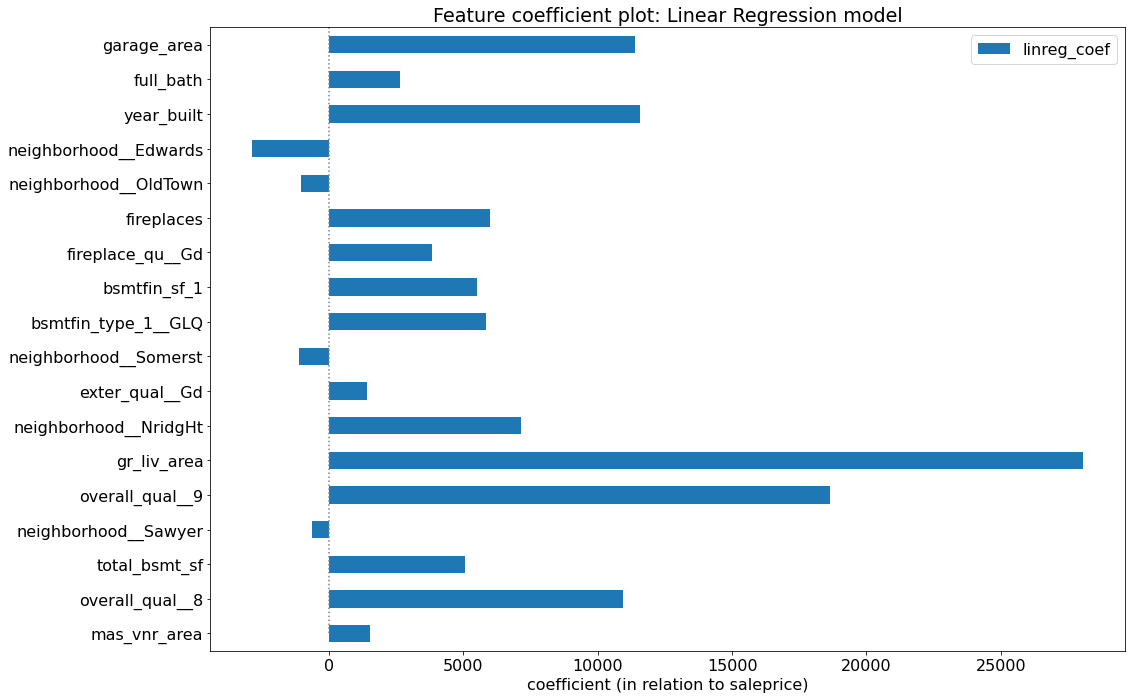

In [172]:
# show model coefficients in a barh plot
# add dummyreg mean to show scale (hidden)

df_linreg_coef = pd.DataFrame(
    data = linreg.coef_, 
    index = list_features_only, 
    columns = ['linreg_coef']
)

df_linreg_coef.plot.barh(figsize = (16,10))
plt.xlabel('coefficient (in relation to saleprice)')
plt.title('Feature coefficient plot: Linear Regression model')
plt.vlines(x = 0, ymin=0, ymax=18, colors='gray', linestyle='dotted')
# plt.vlines(x = df_dummyreg_1.mean(), ymin=0, ymax=15, colors='blue', 
#            linestyle='dotted', label='dummyreg mean')
plt.legend()
plt.tight_layout()

plt.savefig('./images/linreg_corr.png')

#### Interpreting coefficients
We mostly see postive coefficients within the mix, with mainly neighborhood locality variables showing some negative coefficients.

For ease of interpretation, we can group our variables into house size, house quality, house features and location.

For House size, bigger is better.
- `gr_live_area`, `bsmftfin_sf_1`, `total_bsmt_sf`, `mas_vnr_area`

For House quality, better is better.
- `overall_qual__*`, `bsmftfin_type_1__GLQ`, `exter_qual__Gd`,  `fireplace_qu__Gd`, `year_built`

For House features, more is better.
-`full_bath`,  `fireplaces`

For Neighborhood / location, it depends on nature of district
- `neighborhood__*` variables
- Only Northridge Heights (NrdgHt) showed a stronger positive coefficient, whereas other locations had negative coefficients.

[Back to contents](#Content)

### Conclusions and Further Research

Perhaps as one might have predicted independently of this analysis, house size, house quality, house features, and housing location do have a demonstrable impact on how much a house can go for on the market.

It is important to understand that there are many direct features of the house itself and it is often very difficult to judge human behavior in establishing a reasonable price. While we visit only 18 features in this model, we are predicting ~80% of the sale price, and this is generally good enough as a ballpark figure.

Beyond this, time-series information as well as past sales prices become increasingly relevant, as well as buyer profiles: for example, speculative / investment asset purchases would be very different in nature from purchases for personal stay.

Also, one should note that the applicability of this model is restricted in many ways to the Ames, Iowa, area. We would not, for example, expect this model to work at all in Singapore, where it would be quite unrealistic to evaluate number of fireplaces a house has.

Given more time, it could be interesting to engineer some features dealing with price per square foot on an assessable net living area. Understanding how the overall quality surveys may also be interesting.

### References & Bibliography

1. Data USA. (n.d.). Ames, IA. Retrieved December 24, 2021, from https://datausa.io/profile/geo/ames-ia-31000US11180#housing

2. Data Commons. (n.d.). Ames - Place Explorer - Data Commons. Data Commons Place Explorer. Retrieved December 28, 2021, from https://datacommons.org/place/geoId/1901855?utm_medium=explore&mprop=count&popt=HousingUnit&hl=en#

3. De Cock, D. (n.d.). Ames Iowa: Alternative to the Boston Housing Data Set. Retrieved December 28, 2021, from http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

4. Kuiper , S. (2008), “Introduction to Multiple Regression: How Much Is Your Car Worth?”, Journal of Statistics Education Volume 16, Number 3 (2008).

5. Pardoe , I. (2008), “Modeling home prices using realtor data”, Journal of Statistics Education Volume 16, Number 2 (2008).



[Back to contents](#Content)